In [1]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [3]:
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics

## define helper functions

In [184]:
def get_relevant_key_word_tokens(df_col):
    '''Takes a data frame and column name and returns a list of key word tokens'''
    # make sure the column is strings
    for cell in df_col:
        assert(type(cell) == str)
    text_list = [t.lower() for t in df_col]
    text_string = ''
    for t in text_list:
        text_string = text_string + t + ' '
    text_tokens = [w for w in word_tokenize(text_string) if (w.isalnum() and w not in stopwords.words('english'))]
    key_tokens = pd.DataFrame(Counter(text_tokens).most_common(10))
    #key_tokens = pd.DataFrame(Counter(text_tokens).most_common()).tail(10)
    key_tokens.columns = ['key_tok', 'kt_count']
    return key_tokens


def define_nominated_paragraphs(filing, key_tokens, margin):
    '''takes an html filing, key_tokens, paragraph margin and returns nominated paragraphs'''
    
    # read in an html
    with open(filing) as file:
        file_html = file.read()
        
    # parse html
    parsed_html = BeautifulSoup(file_html, 'lxml')
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ##################------- Predict Paragraphs ------##############################################
    #define candidate paragraphs by addin margins to each hit
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraph bounds
    candidate_paragraphs = []
    
    for i in range(len(flater_list_of_tokhits)):
    #    
    #    # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[i][1] - margin
        rightbound = flater_list_of_tokhits[i][2] + margin
        
        # ensure bounds are not out of index range
        if leftbound < 0:
            leftbound = 0
        if rightbound > len(string_filing):
            rightbound = len(string_filing)

        par_bounds = (leftbound, rightbound) 
        candidate_paragraphs.append(par_bounds)
    
    return candidate_paragraphs, string_filing

## read, clean original csv

In [101]:
#read in the csv
share_rprchs_prgrph_df = pd.read_csv('data/share_repurchase_paragraphs.csv')
share_rprchs_prgrph_df.head(2)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."


In [103]:
# get the indices of the duplicate rows
dups = list(share_rprchs_prgrph_df[share_rprchs_prgrph_df.duplicated()].index)
#dups

# drop the duplicate rows (there was probably a more elegant way to do this... )
share_rprchs_prgrph_df = share_rprchs_prgrph_df[[i not in dups for i in share_rprchs_prgrph_df.index]]
share_rprchs_prgrph_df.reset_index(inplace=True, drop = True)
#share_rprchs_prgrph_df.info()

In [104]:
print('word' in 'This Longer String with Word')
print('word' in 'This longer string with words')

False
True


In [105]:
# count the number of pre-processed cells not in their pre-processed par cell
txt_not_in_par_count = 0
untrue_dkfns = []
for i in share_rprchs_prgrph_df.index:
    # preprocess the comparison:
    txt = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.text[i])
    txt = re.sub(r'\s+', ' ', txt)
    txt = txt.lower()
    partxt = re.sub(r'\n+', ' ', share_rprchs_prgrph_df.paragraph_text[i])
    partxt = re.sub(r'\s+', ' ', partxt)
    partxt = partxt.lower()
    if txt not in partxt:
        #print('found row with text not in paragraph at index ', i)
        txt_not_in_par_count +=1
        untrue_dkfns.append(share_rprchs_prgrph_df.data_key_friendly_name[i])
print('number of texts not in their row paragraph ', txt_not_in_par_count)
print('that is a percentage of ', 100*txt_not_in_par_count/len(share_rprchs_prgrph_df.index), '%')

number of texts not in their row paragraph  19
that is a percentage of  1.072234762979684 %


Turns out that with a little preprocessing only there is only a 1% non-correspondance between text and paragraph, which itself may be resolved by some other preprocessing.
- that is sufficiently small that I wouldn't worry about leaving it in there for my training and fitting. 

# Strategy 2.0
1. split csv into training and test sets
2. predict paragraphs for training set
    - 2.a) validate against actual paragraphs
3. predict paragraphs for test set
    - 3.a) validate against actual paragraphs

## 2. Predict Paragraphs for training set
**Requires:**
- margin generated from training paragraph lengths
- 7 key_tok sets generated from 7 slices of training paragraph lengths
- 7 models generated from 7 slices of training paragraph lengths

**For each row in training_df**

- identify that row's dkfn
- generate nominee paragraphs
    - using that dkfn's margin
    - using that dkfn's key_toks
- use that dkfn's model to pick one paragraph
    - use the mod.pred_proba() on the paragraphs and select the one with highest probability
- write that paragraph to the training dataframe

In [106]:
# initialize 7 margins
margins = {'amount': 600,
          'authorization': 600,
          'date' : 600,
          'count' : 600,
          'intention' : 600,
          'utilization':600,
          'unknown':600}

### fit and train a paragraph ranking model for each dkfn

In [107]:
share_rprchs_prgrph_df['pred_par'] = None

In [174]:
share_rprchs_prgrph_df['pred_proba'] = None

In [108]:
# add encoded classification columns
dummies = pd.get_dummies(share_rprchs_prgrph_df.data_key_friendly_name)
dummies.columns = ['amount', 'authorization', 'date', 'count', 'intention', 'utilization', 'unknown']
#dummies.head(2)

In [109]:
share_rprchs_prgrph_df = pd.concat([share_rprchs_prgrph_df, dummies], axis=1)

In [110]:
share_rprchs_prgrph_df.head(1)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,amount,authorization,date,count,intention,utilization,unknown
0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.0,ones,"On May 28, 2015 we announced that our board ...",None,0,0,1,0,0,0,0


In [28]:
# split data into train, fit and test subsets
X_train, X_test, y_train_ix, y_test_ix = train_test_split(share_rprchs_prgrph_df.paragraph_text,
                                                   share_rprchs_prgrph_df.index, ### Watchout this is just a placeholder for now
                                                   test_size = 0.33,
                                                   random_state = 53)
# initialize a TfidfVectorizer object
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df = 0.7)

In [29]:
# transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(X_train)

# transform the test data
tfidf_test = tfidf_vectorizer.transform(X_test)

In [30]:
# make and fit a model for each dkfn
nb_amnt_classifier = MultinomialNB()
nb_amnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.amount[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_auth_classifier = MultinomialNB()
nb_auth_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_dt_classifier = MultinomialNB()
nb_dt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.date[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_cnt_classifier = MultinomialNB()
nb_cnt_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df['count'][[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_intent_classifier = MultinomialNB()
nb_intent_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.intention[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_util_classifier = MultinomialNB()
nb_util_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.utilization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])
nb_unk_classifier = MultinomialNB()
nb_unk_classifier.fit(tfidf_train, 
                       share_rprchs_prgrph_df.unknown[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]])


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

**Validate the seven models**

In [31]:
models_lst = [nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]

for mod, col in zip(models_lst, ['amount', 'authorization', 'count' ,'date', 'intention', 'unknown', 'utilization']):
    pred = mod.predict(tfidf_test)
    score = metrics.accuracy_score(share_rprchs_prgrph_df[col][[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]], pred)
    print(round(100*score, 1), '%', col, 'accuracy')

80.7 % amount accuracy
80.0 % authorization accuracy
84.8 % count accuracy
77.3 % date accuracy
86.3 % intention accuracy
93.2 % unknown accuracy
97.8 % utilization accuracy


### Define the dkfn slices

In [32]:
unk_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Unknown Share Repurchase Data']
#unk_df.info()

In [33]:
util_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Utilization']
#util_df.info()

In [34]:
shrp_intent_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Intention']
#shrp_intent_df.info()

In [35]:
shrp_count_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Count']
#shrp_count_df.info()

In [36]:
auth_dt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization Date']
#auth_dt_df.info()

In [37]:
auth_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Share Repurchase Authorization']
#auth_df.info()

In [38]:
amnt_spnt_df = share_rprchs_prgrph_df[share_rprchs_prgrph_df.data_key_friendly_name == 'Amount Spent on Share Repurchases']
#amnt_spnt_df.info()

In [39]:
# spot check that the text column is only strings
for c in share_rprchs_prgrph_df.text:
    assert(type('str') == type(c))

In [40]:
dkfn_slices = [unk_df, util_df, shrp_count_df, shrp_intent_df, 
               auth_df, auth_dt_df, amnt_spnt_df]

In [41]:
type(dkfn_slices[0])

pandas.core.frame.DataFrame

In [190]:
## use dictionary to assign models in loop
'''[nb_amnt_classifier, nb_auth_classifier, nb_cnt_classifier, nb_dt_classifier,
             nb_intent_classifier, nb_unk_classifier, nb_util_classifier]'''

models_dict ={}
for mdl, k in zip(models_lst,
                 ['spent_model', 'auth_model', 'count_model', 'date_model', 
                  'intent_model', 'unk_model', 'util_model']):
    models_dict['{0}'.format(k)] = mdl


In [112]:
# use dictionary to assign variables in loop:
dkfn_kts_dict = {}
for slc, k in zip(dkfn_slices, 
                  ['unk_kts', 'util_kts', 'count_kts', 'intent_kts', 'auth_kts', 'date_kts', 'spent_kts']):
    dkfn_kts_dict['{0}'.format(k)] = get_relevant_key_word_tokens(slc.text)
    
#print(dkfn_kts_dict)

In [113]:
dkfn_kts_dict['unk_kts']

,key_tok,kt_count
0,repurchase,74
1,board,54
2,authorized,52
3,directors,49
4,program,31
5,shares,25
6,company,24
7,authorization,18
8,share,15
9,approved,12


### stage filings to be iteratively read in

In [44]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

In [45]:
assert True == False

AssertionError: 

## make an inclusion measuring function
(since I can't strictly validate on similar but non-equal paragraphs)

In [89]:
# for predicted paragraph
def measure_inclusion(predicted_par, test_par, verbose = False):
    
    # pre process paragraphs and generate tokens
    pred = re.sub(r'\n+', ' ', predicted_par)
    pred = re.sub(r'\s+', ' ', pred)
    pred = pred.lower()
    pred_tokens = [wt for wt in word_tokenize(pred) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    test = re.sub(r'\n+', ' ', test_par)
    test = re.sub(r'\s+', ' ', test)
    test = test.lower()
    test_tokens = [wt for wt in word_tokenize(test) if (wt.isalnum() and wt not in stopwords.words('english'))]
    
    # calculate total inclusion
    total_inclusion = False
    if test in pred:
        total_inclusion = True
    # calculate test-inclusion percentage ()
    counter = 0
    for wt in test_tokens:
        if wt in pred_tokens:
            counter +=1
    inclusion_pct = round(100*counter/len(test_tokens), 2)
    
    # calculate extra baggage percentage
    bag_counter = 0
    for wt in pred_tokens:
        if wt not in test_tokens:
            bag_counter += 1
    baggage_pct = round(100*bag_counter/len(pred_tokens), 2)
    
    # package results for output
    results = {'total_inclusion' : total_inclusion,
              'inclusion_pct' : inclusion_pct,
              'baggage_pct': baggage_pct,
              'pred_tokenized_par_len': len(pred_tokens),
              'test_tokenized_par_len': len(test_tokens)}
    
    # reporting
    if verbose == True:
        print(results)
    
    return results
    

In [90]:
measure_inclusion(nominee+'noise', nominee, verbose = False)

{'total_inclusion': True,
 'inclusion_pct': 100.0,
 'baggage_pct': 0.84,
 'pred_tokenized_par_len': 119,
 'test_tokenized_par_len': 118}

In [73]:
nominee

". shareholders' equity common stock repurchase program for the years ended december 31, 2016 and 2015, the number of shares repurchased pursuant to trading plans under rule 10b5-1 of the securities exchange act of 1934, as amended, were 31 million and 45 million, respectively, and their costs were $2.307 billion and $3.600 billion, respectively. there were no shares repurchased in the year ended december 31, 2017. in january 2016, time warner's board of directors authorized up to $5.0 billion of share repurchases beginning january 1, 2016, including amounts available under the company's prior stock repurchase program at december 31, 2015. purchases under the stock repurchase program may be made on the open market or in privately negotiated transactions, with the size and timing of these purchases based on a number of factors, including price and business and market conditions. in connection with entering into the merger agreement, the company discontinued share repurchases under the s

In [128]:
'''for k in dkfn_kts_dict.keys():
    trimmed_key = re.sub('_kts', '', k)
    print("")
    print('-- key is', trimmed_key)
    print(share_rprchs_prgrph_df.data_key_friendly_name[0].lower())
    if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[0].lower():
        if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[0].lower():
            continue
        print('✅ ', 'match')'''

'for k in dkfn_kts_dict.keys():\n    trimmed_key = re.sub(\'_kts\', \'\', k)\n    print("")\n    print(\'-- key is\', trimmed_key)\n    print(share_rprchs_prgrph_df.data_key_friendly_name[0].lower())\n    if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[0].lower():\n        if trimmed_key == \'auth\' and \'date\' in share_rprchs_prgrph_df.data_key_friendly_name[0].lower():\n            continue\n        print(\'✅ \', \'match\')'

# For each filing
## predict and validate paragraph

In [191]:
set(share_rprchs_prgrph_df.data_key_friendly_name)

{'Amount Spent on Share Repurchases',
 'Share Repurchase Authorization',
 'Share Repurchase Authorization Date',
 'Share Repurchase Count',
 'Share Repurchase Intention',
 'Share Repurchase Utilization',
 'Unknown Share Repurchase Data'}

In [196]:
# initialize some data containers
total_inclusion = []
inclusion_rates = []
extra_baggage_rate = []
actual_paratokens_lengths = []
nominated_paratokens_lengths = []


for i in range(len(training_filings_list)):
    filing = training_filings_list[i]
    ti = datetime.datetime.now()
    print(ti, 'working on filing ', i, 'out of', len(training_filings_list))
    # filter down to that filings dataframe rows
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    
    # for each dkfn_row in df_slice
    for i in share_rprchs_prgrph_df.data_key_friendly_name[share_rprchs_prgrph_df.accession_number == an].index:
        to = datetime.datetime.now()
        print(to, '-- working on', share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
        
        # If there is already a prediction move on to the next row
        if share_rprchs_prgrph_df.pred_proba[i] != None:
        #if share_rprchs_prgrph_df.pred_proba[i] != None and 'Count' not in share_rprchs_prgrph_df.data_key_friendly_name[i]:
            print("---- already made a prediction for", share_rprchs_prgrph_df.ticker[i], share_rprchs_prgrph_df.data_key_friendly_name[i])
            continue
        
        # select appropriate dkfn key_tokens
        for k in dkfn_kts_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_kts', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                key_tokens = dkfn_kts_dict[k]
                print(datetime.datetime.now(), '------ using key_tokens for', k)
        
        #predict a pragraph using that rows dkfn's margin and key toks
        nominees, string_filing = define_nominated_paragraphs(filing, key_tokens, margin)
        
        # select appropriate model for dkfn
        for k in models_dict.keys():
            # trim the name of the key
            trimmed_key = re.sub('_model', '', k)
            # check to see if it is in the dkfn column.lower()
            if trimmed_key in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                # for authorization, distinguish between generic auth and auth_date
                if trimmed_key == 'auth' and 'date' in share_rprchs_prgrph_df.data_key_friendly_name[i].lower():
                    continue
                # if so, then assign that kts df
                model = models_dict[k]
                print(datetime.datetime.now(), '------ using model for ', k)
        
        #pred_par = par_with_highest_kt_hit_density or par_with_models_highest_pred_proba
        pred_dct = get_tfidf_ML_paragraph(nominees, string_filing, model, verbose = False, inverse= True)
        pred_par = pred_dct['nominee']
        
        # write the paragraph to the df
        share_rprchs_prgrph_df.pred_par[i] = pred_par
        share_rprchs_prgrph_df.pred_proba[i] = pred_dct['best_proba']
        print(datetime.datetime.now(), '---------- wrote predicted paragraph. row took', datetime.datetime.now() - ti)
        
        # score the inclusion
        results_dct = measure_inclusion(pred_par, share_rprchs_prgrph_df.paragraph_text[i], verbose = False)
        print(datetime.datetime.now(), "measured inclusion.")
        print("="*75)
        # store the inclusion data
        total_inclusion.append(results_dct['total_inclusion'])
        inclusion_rates.append(results_dct['inclusion_pct'])
        extra_baggage_rate.append(results_dct['baggage_pct'])
        actual_paratokens_lengths.append(results_dct['test_tokenized_par_len'])
        nominated_paratokens_lengths.append(results_dct['pred_tokenized_par_len'])

2018-06-09 03:49:38.835041 working on filing  0 out of 435
2018-06-09 03:49:38.836589 -- working on RMD Unknown Share Repurchase Data
---- already made a prediction for RMD Unknown Share Repurchase Data
2018-06-09 03:49:38.837490 -- working on RMD Share Repurchase Authorization Date
---- already made a prediction for RMD Share Repurchase Authorization Date
2018-06-09 03:49:38.838007 -- working on RMD Unknown Share Repurchase Data
---- already made a prediction for RMD Unknown Share Repurchase Data
2018-06-09 03:49:38.838449 working on filing  1 out of 435
2018-06-09 03:49:38.840405 -- working on AMGN Share Repurchase Authorization Date
---- already made a prediction for AMGN Share Repurchase Authorization Date
2018-06-09 03:49:38.840855 -- working on AMGN Share Repurchase Authorization
---- already made a prediction for AMGN Share Repurchase Authorization
2018-06-09 03:49:38.841184 -- working on AMGN Share Repurchase Authorization
---- already made a prediction for AMGN Share Repurchas

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2018-06-09 03:49:43.174018 ---------- wrote predicted paragraph. row took 0:00:04.335577
2018-06-09 03:49:43.225945 measured inclusion.
2018-06-09 03:49:43.226100 working on filing  2 out of 435
2018-06-09 03:49:43.227284 -- working on ADSK Share Repurchase Count
2018-06-09 03:49:43.227634 ------ using key_tokens for count_kts
2018-06-09 03:49:44.118801 ------ using model for  count_model
2018-06-09 03:49:46.637927 ---------- wrote predicted paragraph. row took 0:00:03.411839
2018-06-09 03:49:46.700969 measured inclusion.
2018-06-09 03:49:46.701044 -- working on ADSK Unknown Share Repurchase Data
---- already made a prediction for ADSK Unknown Share Repurchase Data
2018-06-09 03:49:46.701305 -- working on ADSK Share Repurchase Authorization Date
---- already made a prediction for ADSK Share Repurchase Authorization Date
2018-06-09 03:49:46.701497 -- working on ADSK Unknown Share Repurchase Data
---- already made a prediction for ADSK Unknown Share Repurchase Data
2018-06-09 03:49:46.70

2018-06-09 03:50:19.575720 ------ using model for  count_model
2018-06-09 03:50:22.237324 ---------- wrote predicted paragraph. row took 0:00:03.398905
2018-06-09 03:50:22.291705 measured inclusion.
2018-06-09 03:50:22.291953 working on filing  14 out of 435
2018-06-09 03:50:22.293297 -- working on DHI Share Repurchase Authorization
---- already made a prediction for DHI Share Repurchase Authorization
2018-06-09 03:50:22.293807 -- working on DHI Amount Spent on Share Repurchases
---- already made a prediction for DHI Amount Spent on Share Repurchases
2018-06-09 03:50:22.294132 -- working on DHI Share Repurchase Intention
---- already made a prediction for DHI Share Repurchase Intention
2018-06-09 03:50:22.294493 -- working on DHI Share Repurchase Authorization Date
---- already made a prediction for DHI Share Repurchase Authorization Date
2018-06-09 03:50:22.294816 working on filing  15 out of 435
2018-06-09 03:50:22.296137 -- working on MGM Share Repurchase Count
2018-06-09 03:50:22.2

2018-06-09 03:51:24.617520 ------ using model for  count_model
2018-06-09 03:51:27.764919 ---------- wrote predicted paragraph. row took 0:00:08.061102
2018-06-09 03:51:27.821990 measured inclusion.
2018-06-09 03:51:27.822169 -- working on CCL Share Repurchase Authorization Date
---- already made a prediction for CCL Share Repurchase Authorization Date
2018-06-09 03:51:27.822649 -- working on CCL Share Repurchase Authorization
---- already made a prediction for CCL Share Repurchase Authorization
2018-06-09 03:51:27.823253 working on filing  22 out of 435
2018-06-09 03:51:27.824491 -- working on BF.B Amount Spent on Share Repurchases
---- already made a prediction for BF.B Amount Spent on Share Repurchases
2018-06-09 03:51:27.824995 -- working on BF.B Share Repurchase Utilization
---- already made a prediction for BF.B Share Repurchase Utilization
2018-06-09 03:51:27.825930 -- working on BF.B Share Repurchase Authorization Date
---- already made a prediction for BF.B Share Repurchase Au

2018-06-09 03:51:59.159095 ------ using model for  count_model
2018-06-09 03:52:01.195900 ---------- wrote predicted paragraph. row took 0:00:02.890112
2018-06-09 03:52:01.237237 measured inclusion.
2018-06-09 03:52:01.237371 working on filing  32 out of 435
2018-06-09 03:52:01.238170 -- working on NBL Share Repurchase Authorization
---- already made a prediction for NBL Share Repurchase Authorization
2018-06-09 03:52:01.238485 -- working on NBL Share Repurchase Authorization Date
---- already made a prediction for NBL Share Repurchase Authorization Date
2018-06-09 03:52:01.238879 -- working on NBL Share Repurchase Intention
---- already made a prediction for NBL Share Repurchase Intention
2018-06-09 03:52:01.239184 working on filing  33 out of 435
2018-06-09 03:52:01.239956 -- working on CHRW Share Repurchase Authorization Date
---- already made a prediction for CHRW Share Repurchase Authorization Date
2018-06-09 03:52:01.240710 -- working on CHRW Amount Spent on Share Repurchases
---

2018-06-09 03:52:29.855845 ------ using model for  count_model
2018-06-09 03:52:32.623435 ---------- wrote predicted paragraph. row took 0:00:03.792935
2018-06-09 03:52:32.683338 measured inclusion.
2018-06-09 03:52:32.683421 -- working on SYF Share Repurchase Intention
---- already made a prediction for SYF Share Repurchase Intention
2018-06-09 03:52:32.683713 -- working on SYF Share Repurchase Authorization
---- already made a prediction for SYF Share Repurchase Authorization
2018-06-09 03:52:32.683917 -- working on SYF Amount Spent on Share Repurchases
---- already made a prediction for SYF Amount Spent on Share Repurchases
2018-06-09 03:52:32.684122 working on filing  44 out of 435
2018-06-09 03:52:32.685007 -- working on TROW Share Repurchase Count
2018-06-09 03:52:32.685258 ------ using key_tokens for count_kts
2018-06-09 03:52:33.442460 ------ using model for  count_model
2018-06-09 03:52:35.770360 ---------- wrote predicted paragraph. row took 0:00:03.086248
2018-06-09 03:52:35

2018-06-09 03:52:51.709305 ------ using model for  count_model
2018-06-09 03:52:55.003788 ---------- wrote predicted paragraph. row took 0:00:05.172652
2018-06-09 03:52:55.061577 measured inclusion.
2018-06-09 03:52:55.061718 -- working on DISCA Share Repurchase Intention
---- already made a prediction for DISCA Share Repurchase Intention
2018-06-09 03:52:55.062112 -- working on DISCA Share Repurchase Authorization
---- already made a prediction for DISCA Share Repurchase Authorization
2018-06-09 03:52:55.062399 working on filing  55 out of 435
2018-06-09 03:52:55.063341 -- working on CAH Share Repurchase Authorization
---- already made a prediction for CAH Share Repurchase Authorization
2018-06-09 03:52:55.063967 -- working on CAH Amount Spent on Share Repurchases
---- already made a prediction for CAH Amount Spent on Share Repurchases
2018-06-09 03:52:55.064307 -- working on CAH Share Repurchase Authorization Date
---- already made a prediction for CAH Share Repurchase Authorization 

2018-06-09 03:53:20.977759 ------ using model for  count_model
2018-06-09 03:53:23.494494 ---------- wrote predicted paragraph. row took 0:00:03.696243
2018-06-09 03:53:23.545464 measured inclusion.
2018-06-09 03:53:23.545610 -- working on UPS Amount Spent on Share Repurchases
---- already made a prediction for UPS Amount Spent on Share Repurchases
2018-06-09 03:53:23.545933 working on filing  67 out of 435
2018-06-09 03:53:23.546979 -- working on AVY Share Repurchase Count
2018-06-09 03:53:23.547248 ------ using key_tokens for count_kts
2018-06-09 03:53:24.364328 ------ using model for  count_model
2018-06-09 03:53:26.511941 ---------- wrote predicted paragraph. row took 0:00:02.966018
2018-06-09 03:53:26.562876 measured inclusion.
2018-06-09 03:53:26.563008 -- working on AVY Share Repurchase Authorization Date
---- already made a prediction for AVY Share Repurchase Authorization Date
2018-06-09 03:53:26.563389 -- working on AVY Share Repurchase Authorization
---- already made a predi

2018-06-09 03:53:59.765544 ------ using model for  count_model
2018-06-09 03:54:03.504883 ---------- wrote predicted paragraph. row took 0:00:13.852375
2018-06-09 03:54:03.586875 measured inclusion.
2018-06-09 03:54:03.586968 -- working on PFE Amount Spent on Share Repurchases
---- already made a prediction for PFE Amount Spent on Share Repurchases
2018-06-09 03:54:03.587241 -- working on PFE Share Repurchase Authorization
---- already made a prediction for PFE Share Repurchase Authorization
2018-06-09 03:54:03.587416 -- working on PFE Share Repurchase Authorization Date
---- already made a prediction for PFE Share Repurchase Authorization Date
2018-06-09 03:54:03.587587 -- working on PFE Share Repurchase Authorization
---- already made a prediction for PFE Share Repurchase Authorization
2018-06-09 03:54:03.587758 -- working on PFE Share Repurchase Intention
---- already made a prediction for PFE Share Repurchase Intention
2018-06-09 03:54:03.587942 working on filing  74 out of 435
201

2018-06-09 03:54:31.949736 ------ using model for  count_model
2018-06-09 03:54:34.214037 ---------- wrote predicted paragraph. row took 0:00:03.400739
2018-06-09 03:54:34.249191 measured inclusion.
2018-06-09 03:54:34.249342 working on filing  85 out of 435
2018-06-09 03:54:34.250195 -- working on EMN Share Repurchase Utilization
---- already made a prediction for EMN Share Repurchase Utilization
2018-06-09 03:54:34.250471 -- working on EMN Share Repurchase Authorization Date
---- already made a prediction for EMN Share Repurchase Authorization Date
2018-06-09 03:54:34.250634 -- working on EMN Amount Spent on Share Repurchases
---- already made a prediction for EMN Amount Spent on Share Repurchases
2018-06-09 03:54:34.250793 -- working on EMN Share Repurchase Intention
---- already made a prediction for EMN Share Repurchase Intention
2018-06-09 03:54:34.250950 -- working on EMN Share Repurchase Authorization
---- already made a prediction for EMN Share Repurchase Authorization
2018-06

2018-06-09 03:54:55.340049 ------ using model for  count_model
2018-06-09 03:54:58.010567 ---------- wrote predicted paragraph. row took 0:00:04.059828
2018-06-09 03:54:58.045743 measured inclusion.
2018-06-09 03:54:58.045837 -- working on HOG Unknown Share Repurchase Data
---- already made a prediction for HOG Unknown Share Repurchase Data
2018-06-09 03:54:58.046157 -- working on HOG Unknown Share Repurchase Data
---- already made a prediction for HOG Unknown Share Repurchase Data
2018-06-09 03:54:58.046430 -- working on HOG Share Repurchase Authorization Date
---- already made a prediction for HOG Share Repurchase Authorization Date
2018-06-09 03:54:58.046642 working on filing  97 out of 435
2018-06-09 03:54:58.047597 -- working on BAX Share Repurchase Intention
---- already made a prediction for BAX Share Repurchase Intention
2018-06-09 03:54:58.047966 -- working on BAX Share Repurchase Count
2018-06-09 03:54:58.048192 ------ using key_tokens for count_kts
2018-06-09 03:54:58.946928

2018-06-09 03:55:13.556671 ------ using model for  count_model
2018-06-09 03:55:15.718372 ---------- wrote predicted paragraph. row took 0:00:02.868896
2018-06-09 03:55:15.753932 measured inclusion.
2018-06-09 03:55:15.754045 -- working on XLNX Share Repurchase Authorization Date
---- already made a prediction for XLNX Share Repurchase Authorization Date
2018-06-09 03:55:15.754433 working on filing  106 out of 435
2018-06-09 03:55:15.755307 -- working on MDT Share Repurchase Count
2018-06-09 03:55:15.756362 ------ using key_tokens for count_kts
2018-06-09 03:55:18.035546 ------ using model for  count_model
2018-06-09 03:55:20.608563 ---------- wrote predicted paragraph. row took 0:00:04.854141
2018-06-09 03:55:20.685567 measured inclusion.
2018-06-09 03:55:20.685705 -- working on MDT Share Repurchase Authorization
---- already made a prediction for MDT Share Repurchase Authorization
2018-06-09 03:55:20.686000 -- working on MDT Share Repurchase Authorization Date
---- already made a pre

2018-06-09 03:55:52.714730 ------ using model for  count_model
2018-06-09 03:55:54.759989 ---------- wrote predicted paragraph. row took 0:00:02.762203
2018-06-09 03:55:54.791351 measured inclusion.
2018-06-09 03:55:54.791494 -- working on NTAP Share Repurchase Authorization Date
---- already made a prediction for NTAP Share Repurchase Authorization Date
2018-06-09 03:55:54.792003 -- working on NTAP Share Repurchase Authorization
---- already made a prediction for NTAP Share Repurchase Authorization
2018-06-09 03:55:54.792247 working on filing  116 out of 435
2018-06-09 03:55:54.793305 -- working on RE Amount Spent on Share Repurchases
---- already made a prediction for RE Amount Spent on Share Repurchases
2018-06-09 03:55:54.793717 -- working on RE Share Repurchase Count
2018-06-09 03:55:54.793922 ------ using key_tokens for count_kts
2018-06-09 03:55:57.629299 ------ using model for  count_model
2018-06-09 03:56:00.352092 ---------- wrote predicted paragraph. row took 0:00:05.559856


2018-06-09 03:56:23.743185 ------ using model for  count_model
2018-06-09 03:56:26.919584 ---------- wrote predicted paragraph. row took 0:00:06.022139
2018-06-09 03:56:26.996713 measured inclusion.
2018-06-09 03:56:26.996881 -- working on AXP Share Repurchase Authorization
---- already made a prediction for AXP Share Repurchase Authorization
2018-06-09 03:56:26.997325 working on filing  128 out of 435
2018-06-09 03:56:26.998501 -- working on DE Share Repurchase Authorization Date
---- already made a prediction for DE Share Repurchase Authorization Date
2018-06-09 03:56:26.998912 -- working on DE Share Repurchase Authorization
---- already made a prediction for DE Share Repurchase Authorization
2018-06-09 03:56:26.999228 -- working on DE Share Repurchase Intention
---- already made a prediction for DE Share Repurchase Intention
2018-06-09 03:56:26.999691 working on filing  129 out of 435
2018-06-09 03:56:27.000623 -- working on AIG Share Repurchase Authorization Date
---- already made 

2018-06-09 03:56:57.364273 ------ using model for  count_model
2018-06-09 03:57:01.144333 ---------- wrote predicted paragraph. row took 0:00:05.313633
2018-06-09 03:57:01.193364 measured inclusion.
2018-06-09 03:57:01.193482 -- working on COTY Share Repurchase Authorization
---- already made a prediction for COTY Share Repurchase Authorization
2018-06-09 03:57:01.193845 working on filing  138 out of 435
2018-06-09 03:57:01.194745 -- working on ZTS Share Repurchase Authorization Date
---- already made a prediction for ZTS Share Repurchase Authorization Date
2018-06-09 03:57:01.195012 -- working on ZTS Share Repurchase Count
2018-06-09 03:57:01.195357 ------ using key_tokens for count_kts
2018-06-09 03:57:02.255939 ------ using model for  count_model
2018-06-09 03:57:04.903060 ---------- wrote predicted paragraph. row took 0:00:03.709228
2018-06-09 03:57:04.959664 measured inclusion.
2018-06-09 03:57:04.959762 -- working on ZTS Share Repurchase Authorization
---- already made a predicti

2018-06-09 03:57:28.078513 ------ using model for  count_model
2018-06-09 03:57:30.600165 ---------- wrote predicted paragraph. row took 0:00:04.808401
2018-06-09 03:57:30.628873 measured inclusion.
2018-06-09 03:57:30.628991 -- working on CBS Amount Spent on Share Repurchases
---- already made a prediction for CBS Amount Spent on Share Repurchases
2018-06-09 03:57:30.629272 -- working on CBS Share Repurchase Intention
---- already made a prediction for CBS Share Repurchase Intention
2018-06-09 03:57:30.629436 working on filing  149 out of 435
2018-06-09 03:57:30.630223 -- working on DGX Share Repurchase Authorization Date
---- already made a prediction for DGX Share Repurchase Authorization Date
2018-06-09 03:57:30.630515 -- working on DGX Amount Spent on Share Repurchases
---- already made a prediction for DGX Amount Spent on Share Repurchases
2018-06-09 03:57:30.630688 -- working on DGX Share Repurchase Intention
---- already made a prediction for DGX Share Repurchase Intention
2018

2018-06-09 03:57:53.179893 ------ using model for  count_model
2018-06-09 03:57:55.377232 ---------- wrote predicted paragraph. row took 0:00:02.950105
2018-06-09 03:57:55.417317 measured inclusion.
2018-06-09 03:57:55.417437 working on filing  158 out of 435
2018-06-09 03:57:55.418475 -- working on PX Share Repurchase Authorization
---- already made a prediction for PX Share Repurchase Authorization
2018-06-09 03:57:55.418754 -- working on PX Share Repurchase Intention
---- already made a prediction for PX Share Repurchase Intention
2018-06-09 03:57:55.418963 -- working on PX Share Repurchase Utilization
---- already made a prediction for PX Share Repurchase Utilization
2018-06-09 03:57:55.419257 -- working on PX Share Repurchase Authorization Date
---- already made a prediction for PX Share Repurchase Authorization Date
2018-06-09 03:57:55.419488 working on filing  159 out of 435
2018-06-09 03:57:55.420134 -- working on JNPR Share Repurchase Authorization
---- already made a predicti

2018-06-09 03:58:20.039818 ---------- wrote predicted paragraph. row took 0:00:03.797630
2018-06-09 03:58:20.114917 measured inclusion.
2018-06-09 03:58:20.115023 -- working on SBAC Amount Spent on Share Repurchases
---- already made a prediction for SBAC Amount Spent on Share Repurchases
2018-06-09 03:58:20.115527 -- working on SBAC Share Repurchase Authorization Date
---- already made a prediction for SBAC Share Repurchase Authorization Date
2018-06-09 03:58:20.115857 working on filing  169 out of 435
2018-06-09 03:58:20.117889 -- working on MYL Share Repurchase Authorization
---- already made a prediction for MYL Share Repurchase Authorization
2018-06-09 03:58:20.118864 -- working on MYL Share Repurchase Authorization Date
---- already made a prediction for MYL Share Repurchase Authorization Date
2018-06-09 03:58:20.119184 -- working on MYL Amount Spent on Share Repurchases
---- already made a prediction for MYL Amount Spent on Share Repurchases
2018-06-09 03:58:20.119405 -- working

2018-06-09 03:58:43.707998 ------ using model for  count_model
2018-06-09 03:58:45.801013 ---------- wrote predicted paragraph. row took 0:00:02.966354
2018-06-09 03:58:45.830612 measured inclusion.
2018-06-09 03:58:45.830691 -- working on KR Share Repurchase Intention
---- already made a prediction for KR Share Repurchase Intention
2018-06-09 03:58:45.830976 -- working on KR Amount Spent on Share Repurchases
---- already made a prediction for KR Amount Spent on Share Repurchases
2018-06-09 03:58:45.831205 -- working on KR Share Repurchase Authorization
---- already made a prediction for KR Share Repurchase Authorization
2018-06-09 03:58:45.831431 -- working on KR Share Repurchase Authorization Date
---- already made a prediction for KR Share Repurchase Authorization Date
2018-06-09 03:58:45.831612 working on filing  181 out of 435
2018-06-09 03:58:45.832375 -- working on BLK Unknown Share Repurchase Data
---- already made a prediction for BLK Unknown Share Repurchase Data
2018-06-09 0

2018-06-09 03:59:09.854220 ------ using model for  count_model
2018-06-09 03:59:11.687802 ---------- wrote predicted paragraph. row took 0:00:02.319890
2018-06-09 03:59:11.725939 measured inclusion.
2018-06-09 03:59:11.726755 -- working on COST Share Repurchase Intention
---- already made a prediction for COST Share Repurchase Intention
2018-06-09 03:59:11.728482 -- working on COST Share Repurchase Authorization Date
---- already made a prediction for COST Share Repurchase Authorization Date
2018-06-09 03:59:11.730086 working on filing  195 out of 435
2018-06-09 03:59:11.732338 -- working on ZBH Share Repurchase Authorization Date
---- already made a prediction for ZBH Share Repurchase Authorization Date
2018-06-09 03:59:11.732733 -- working on ZBH Share Repurchase Intention
---- already made a prediction for ZBH Share Repurchase Intention
2018-06-09 03:59:11.733049 -- working on ZBH Share Repurchase Authorization
---- already made a prediction for ZBH Share Repurchase Authorization
20

2018-06-09 03:59:43.194796 ------ using model for  count_model
2018-06-09 03:59:45.587907 ---------- wrote predicted paragraph. row took 0:00:03.820548
2018-06-09 03:59:45.635738 measured inclusion.
2018-06-09 03:59:45.635888 -- working on PSX Amount Spent on Share Repurchases
---- already made a prediction for PSX Amount Spent on Share Repurchases
2018-06-09 03:59:45.636574 working on filing  205 out of 435
2018-06-09 03:59:45.637357 -- working on MHK Unknown Share Repurchase Data
---- already made a prediction for MHK Unknown Share Repurchase Data
2018-06-09 03:59:45.637674 -- working on MHK Unknown Share Repurchase Data
---- already made a prediction for MHK Unknown Share Repurchase Data
2018-06-09 03:59:45.637970 -- working on MHK Share Repurchase Authorization Date
---- already made a prediction for MHK Share Repurchase Authorization Date
2018-06-09 03:59:45.638224 -- working on MHK Share Repurchase Utilization
---- already made a prediction for MHK Share Repurchase Utilization
20

2018-06-09 04:00:04.631165 ------ using model for  count_model
2018-06-09 04:00:07.609867 ---------- wrote predicted paragraph. row took 0:00:03.767664
2018-06-09 04:00:07.670943 measured inclusion.
2018-06-09 04:00:07.671077 -- working on TJX Share Repurchase Authorization
---- already made a prediction for TJX Share Repurchase Authorization
2018-06-09 04:00:07.671440 -- working on TJX Share Repurchase Authorization
---- already made a prediction for TJX Share Repurchase Authorization
2018-06-09 04:00:07.671640 -- working on TJX Share Repurchase Authorization Date
---- already made a prediction for TJX Share Repurchase Authorization Date
2018-06-09 04:00:07.671838 working on filing  217 out of 435
2018-06-09 04:00:07.673148 -- working on HLT Share Repurchase Authorization Date
---- already made a prediction for HLT Share Repurchase Authorization Date
2018-06-09 04:00:07.673404 -- working on HLT Share Repurchase Intention
---- already made a prediction for HLT Share Repurchase Intentio

2018-06-09 04:00:52.954041 ------ using model for  date_model
2018-06-09 04:00:58.532688 ---------- wrote predicted paragraph. row took 0:00:33.882475
2018-06-09 04:00:58.566040 measured inclusion.
2018-06-09 04:00:58.566169 working on filing  226 out of 435
2018-06-09 04:00:58.567179 -- working on KORS Share Repurchase Intention
2018-06-09 04:00:58.567456 ------ using key_tokens for intent_kts
2018-06-09 04:00:59.189356 ------ using model for  intent_model
2018-06-09 04:01:01.597484 ---------- wrote predicted paragraph. row took 0:00:03.031327
2018-06-09 04:01:01.645909 measured inclusion.
2018-06-09 04:01:01.646011 -- working on KORS Amount Spent on Share Repurchases
2018-06-09 04:01:01.646388 ------ using key_tokens for spent_kts
2018-06-09 04:01:02.283369 ------ using model for  spent_model
2018-06-09 04:01:04.688562 ---------- wrote predicted paragraph. row took 0:00:06.122406
2018-06-09 04:01:04.741971 measured inclusion.
2018-06-09 04:01:04.742062 -- working on KORS Share Repurc

2018-06-09 04:02:09.098923 ------ using model for  unk_model
2018-06-09 04:02:11.882410 ---------- wrote predicted paragraph. row took 0:00:05.792441
2018-06-09 04:02:11.945963 measured inclusion.
2018-06-09 04:02:11.946143 -- working on CINF Share Repurchase Authorization Date
2018-06-09 04:02:11.946572 ------ using key_tokens for date_kts
2018-06-09 04:02:14.910441 ------ using model for  date_model
2018-06-09 04:02:18.536276 ---------- wrote predicted paragraph. row took 0:00:12.446308
2018-06-09 04:02:18.598143 measured inclusion.
2018-06-09 04:02:18.598257 -- working on CINF Amount Spent on Share Repurchases
2018-06-09 04:02:18.598625 ------ using key_tokens for spent_kts
2018-06-09 04:02:21.676199 ------ using model for  spent_model
2018-06-09 04:02:25.104890 ---------- wrote predicted paragraph. row took 0:00:19.014920
2018-06-09 04:02:25.159893 measured inclusion.
2018-06-09 04:02:25.160018 working on filing  231 out of 435
2018-06-09 04:02:25.160913 -- working on AMP Share Rep

2018-06-09 04:03:35.333231 ------ using model for  unk_model
2018-06-09 04:03:38.540239 ---------- wrote predicted paragraph. row took 0:00:08.565731
2018-06-09 04:03:38.592855 measured inclusion.
2018-06-09 04:03:38.592959 -- working on CNC Unknown Share Repurchase Data
2018-06-09 04:03:38.593204 ------ using key_tokens for unk_kts
2018-06-09 04:03:39.639321 ------ using model for  unk_model
2018-06-09 04:03:42.802749 ---------- wrote predicted paragraph. row took 0:00:12.828243
2018-06-09 04:03:42.857898 measured inclusion.
2018-06-09 04:03:42.858079 working on filing  236 out of 435
2018-06-09 04:03:42.859030 -- working on COP Amount Spent on Share Repurchases
2018-06-09 04:03:42.859435 ------ using key_tokens for spent_kts
2018-06-09 04:03:44.512004 ------ using model for  spent_model
2018-06-09 04:03:47.690643 ---------- wrote predicted paragraph. row took 0:00:04.832571
2018-06-09 04:03:47.736839 measured inclusion.
2018-06-09 04:03:47.736929 -- working on COP Share Repurchase In

2018-06-09 04:05:08.713168 ---------- wrote predicted paragraph. row took 0:00:13.668201
2018-06-09 04:05:08.782510 measured inclusion.
2018-06-09 04:05:08.782740 -- working on HRS Share Repurchase Authorization
2018-06-09 04:05:08.783152 ------ using key_tokens for auth_kts
2018-06-09 04:05:10.243118 ------ using model for  auth_model
2018-06-09 04:05:13.812314 ---------- wrote predicted paragraph. row took 0:00:18.767352
2018-06-09 04:05:13.895809 measured inclusion.
2018-06-09 04:05:13.895914 working on filing  241 out of 435
2018-06-09 04:05:13.896728 -- working on SNPS Share Repurchase Count
2018-06-09 04:05:13.896989 ------ using key_tokens for count_kts
2018-06-09 04:05:14.727780 ------ using model for  count_model
2018-06-09 04:05:17.461620 ---------- wrote predicted paragraph. row took 0:00:03.565715
2018-06-09 04:05:17.509100 measured inclusion.
2018-06-09 04:05:17.509213 -- working on SNPS Amount Spent on Share Repurchases
2018-06-09 04:05:17.509603 ------ using key_tokens f

2018-06-09 04:06:21.479905 ------ using model for  auth_model
2018-06-09 04:06:23.833028 ---------- wrote predicted paragraph. row took 0:00:06.971170
2018-06-09 04:06:23.895018 measured inclusion.
2018-06-09 04:06:23.895132 -- working on MU Share Repurchase Intention
2018-06-09 04:06:23.895464 ------ using key_tokens for intent_kts
2018-06-09 04:06:24.764588 ------ using model for  intent_model
2018-06-09 04:06:27.766592 ---------- wrote predicted paragraph. row took 0:00:10.904734
2018-06-09 04:06:27.825718 measured inclusion.
2018-06-09 04:06:27.825832 -- working on MU Amount Spent on Share Repurchases
2018-06-09 04:06:27.826210 ------ using key_tokens for spent_kts
2018-06-09 04:06:28.677960 ------ using model for  spent_model
2018-06-09 04:06:31.432209 ---------- wrote predicted paragraph. row took 0:00:14.570352
2018-06-09 04:06:31.491183 measured inclusion.
2018-06-09 04:06:31.491301 working on filing  246 out of 435
2018-06-09 04:06:31.492236 -- working on ECL Amount Spent on S

2018-06-09 04:07:45.885171 ---------- wrote predicted paragraph. row took 0:00:05.280667
2018-06-09 04:07:45.911642 measured inclusion.
2018-06-09 04:07:45.911772 -- working on LOW Share Repurchase Authorization
2018-06-09 04:07:45.912143 ------ using key_tokens for auth_kts
2018-06-09 04:07:46.542950 ------ using model for  auth_model
2018-06-09 04:07:48.694287 ---------- wrote predicted paragraph. row took 0:00:08.089784
2018-06-09 04:07:48.731355 measured inclusion.
2018-06-09 04:07:48.731495 -- working on LOW Share Repurchase Authorization
2018-06-09 04:07:48.731885 ------ using key_tokens for auth_kts
2018-06-09 04:07:49.379167 ------ using model for  auth_model
2018-06-09 04:07:51.513617 ---------- wrote predicted paragraph. row took 0:00:10.909113
2018-06-09 04:07:51.552623 measured inclusion.
2018-06-09 04:07:51.552721 -- working on LOW Share Repurchase Authorization Date
2018-06-09 04:07:51.553594 ------ using key_tokens for date_kts
2018-06-09 04:07:52.197276 ------ using mod

2018-06-09 04:09:05.266506 ---------- wrote predicted paragraph. row took 0:00:08.158009
2018-06-09 04:09:05.319802 measured inclusion.
2018-06-09 04:09:05.320041 -- working on SPGI Amount Spent on Share Repurchases
2018-06-09 04:09:05.320622 ------ using key_tokens for spent_kts
2018-06-09 04:09:06.487031 ------ using model for  spent_model
2018-06-09 04:09:09.292948 ---------- wrote predicted paragraph. row took 0:00:12.184454
2018-06-09 04:09:09.347135 measured inclusion.
2018-06-09 04:09:09.347255 -- working on SPGI Unknown Share Repurchase Data
2018-06-09 04:09:09.347518 ------ using key_tokens for unk_kts
2018-06-09 04:09:10.463017 ------ using model for  unk_model
2018-06-09 04:09:12.904452 ---------- wrote predicted paragraph. row took 0:00:15.795954
2018-06-09 04:09:12.965639 measured inclusion.
2018-06-09 04:09:12.965754 -- working on SPGI Unknown Share Repurchase Data
2018-06-09 04:09:12.966002 ------ using key_tokens for unk_kts
2018-06-09 04:09:14.079474 ------ using model

2018-06-09 04:10:35.640237 ------ using model for  spent_model
2018-06-09 04:10:40.180843 ---------- wrote predicted paragraph. row took 0:00:35.350771
2018-06-09 04:10:40.230834 measured inclusion.
2018-06-09 04:10:40.230940 working on filing  260 out of 435
2018-06-09 04:10:40.231866 -- working on JPM Share Repurchase Authorization Date
2018-06-09 04:10:40.232211 ------ using key_tokens for date_kts
2018-06-09 04:10:45.809508 ------ using model for  date_model
2018-06-09 04:10:50.352562 ---------- wrote predicted paragraph. row took 0:00:10.121634
2018-06-09 04:10:50.405618 measured inclusion.
2018-06-09 04:10:50.405732 -- working on JPM Share Repurchase Authorization
2018-06-09 04:10:50.406238 ------ using key_tokens for auth_kts
2018-06-09 04:10:56.442631 ------ using model for  auth_model
2018-06-09 04:10:59.749945 ---------- wrote predicted paragraph. row took 0:00:19.519016
2018-06-09 04:10:59.799491 measured inclusion.
2018-06-09 04:10:59.799569 -- working on JPM Share Repurcha

2018-06-09 04:12:36.504606 ------ using model for  auth_model
2018-06-09 04:12:39.978588 ---------- wrote predicted paragraph. row took 0:00:22.127580
2018-06-09 04:12:40.031034 measured inclusion.
2018-06-09 04:12:40.031149 -- working on MTB Share Repurchase Authorization Date
2018-06-09 04:12:40.031543 ------ using key_tokens for date_kts
2018-06-09 04:12:43.563514 ------ using model for  date_model
2018-06-09 04:12:47.939457 ---------- wrote predicted paragraph. row took 0:00:30.088446
2018-06-09 04:12:47.999264 measured inclusion.
2018-06-09 04:12:47.999464 working on filing  265 out of 435
2018-06-09 04:12:48.001304 -- working on WM Amount Spent on Share Repurchases
2018-06-09 04:12:48.003424 ------ using key_tokens for spent_kts
2018-06-09 04:12:49.065032 ------ using model for  spent_model
2018-06-09 04:12:51.629367 ---------- wrote predicted paragraph. row took 0:00:03.629910
2018-06-09 04:12:51.658384 measured inclusion.
2018-06-09 04:12:51.658535 -- working on WM Share Repurc

2018-06-09 04:14:06.596820 ---------- wrote predicted paragraph. row took 0:00:17.662956
2018-06-09 04:14:06.655424 measured inclusion.
2018-06-09 04:14:06.655598 -- working on BMY Share Repurchase Authorization
2018-06-09 04:14:06.656119 ------ using key_tokens for auth_kts
2018-06-09 04:14:08.008142 ------ using model for  auth_model
2018-06-09 04:14:13.166483 ---------- wrote predicted paragraph. row took 0:00:24.232622
2018-06-09 04:14:13.219579 measured inclusion.
2018-06-09 04:14:13.219690 -- working on BMY Share Repurchase Authorization
2018-06-09 04:14:13.220045 ------ using key_tokens for auth_kts
2018-06-09 04:14:14.792752 ------ using model for  auth_model
2018-06-09 04:14:19.631974 ---------- wrote predicted paragraph. row took 0:00:30.698108
2018-06-09 04:14:19.667941 measured inclusion.
2018-06-09 04:14:19.668486 -- working on BMY Share Repurchase Authorization Date
2018-06-09 04:14:19.669160 ------ using key_tokens for date_kts
2018-06-09 04:14:20.947499 ------ using mod

2018-06-09 04:15:46.009022 ------ using model for  auth_model
2018-06-09 04:15:48.920799 ---------- wrote predicted paragraph. row took 0:00:10.940672
2018-06-09 04:15:48.969996 measured inclusion.
2018-06-09 04:15:48.970165 -- working on MCD Amount Spent on Share Repurchases
2018-06-09 04:15:48.970628 ------ using key_tokens for spent_kts
2018-06-09 04:15:49.788427 ------ using model for  spent_model
2018-06-09 04:15:52.243337 ---------- wrote predicted paragraph. row took 0:00:14.263209
2018-06-09 04:15:52.305849 measured inclusion.
2018-06-09 04:15:52.305956 working on filing  274 out of 435
2018-06-09 04:15:52.306910 -- working on JBHT Share Repurchase Authorization Date
2018-06-09 04:15:52.308060 ------ using key_tokens for date_kts
2018-06-09 04:15:52.632407 ------ using model for  date_model
2018-06-09 04:15:55.172360 ---------- wrote predicted paragraph. row took 0:00:02.866412
2018-06-09 04:15:55.244430 measured inclusion.
2018-06-09 04:15:55.244588 -- working on JBHT Share Re

2018-06-09 04:17:00.974914 ---------- wrote predicted paragraph. row took 0:00:14.912696
2018-06-09 04:17:01.030700 measured inclusion.
2018-06-09 04:17:01.030816 working on filing  279 out of 435
2018-06-09 04:17:01.031753 -- working on HD Amount Spent on Share Repurchases
2018-06-09 04:17:01.032158 ------ using key_tokens for spent_kts
2018-06-09 04:17:01.542880 ------ using model for  spent_model
2018-06-09 04:17:03.936536 ---------- wrote predicted paragraph. row took 0:00:02.905732
2018-06-09 04:17:03.999086 measured inclusion.
2018-06-09 04:17:03.999197 -- working on HD Share Repurchase Count
2018-06-09 04:17:03.999490 ------ using key_tokens for count_kts
2018-06-09 04:17:04.477197 ------ using model for  count_model
2018-06-09 04:17:06.852284 ---------- wrote predicted paragraph. row took 0:00:05.821480
2018-06-09 04:17:06.917417 measured inclusion.
2018-06-09 04:17:06.918150 -- working on HD Share Repurchase Authorization
2018-06-09 04:17:06.919429 ------ using key_tokens for 

2018-06-09 04:18:25.722065 ------ using model for  date_model
2018-06-09 04:18:29.564171 ---------- wrote predicted paragraph. row took 0:00:07.104884
2018-06-09 04:18:29.605458 measured inclusion.
2018-06-09 04:18:29.605535 -- working on HBAN Amount Spent on Share Repurchases
2018-06-09 04:18:29.605896 ------ using key_tokens for spent_kts
2018-06-09 04:18:32.964412 ------ using model for  spent_model
2018-06-09 04:18:36.511178 ---------- wrote predicted paragraph. row took 0:00:14.051892
2018-06-09 04:18:36.570234 measured inclusion.
2018-06-09 04:18:36.570392 -- working on HBAN Share Repurchase Count
2018-06-09 04:18:36.570758 ------ using key_tokens for count_kts
2018-06-09 04:18:39.980932 ------ using model for  count_model
2018-06-09 04:18:43.413359 ---------- wrote predicted paragraph. row took 0:00:20.954068
2018-06-09 04:18:43.462971 measured inclusion.
2018-06-09 04:18:43.463098 -- working on HBAN Share Repurchase Authorization
2018-06-09 04:18:43.463456 ------ using key_toke

2018-06-09 04:20:03.770345 ------ using model for  spent_model
2018-06-09 04:20:06.087086 ---------- wrote predicted paragraph. row took 0:00:03.089597
2018-06-09 04:20:06.123739 measured inclusion.
2018-06-09 04:20:06.123878 -- working on GILD Share Repurchase Count
2018-06-09 04:20:06.124172 ------ using key_tokens for count_kts
2018-06-09 04:20:06.880845 ------ using model for  count_model
2018-06-09 04:20:09.170308 ---------- wrote predicted paragraph. row took 0:00:06.172819
2018-06-09 04:20:09.204754 measured inclusion.
2018-06-09 04:20:09.204882 -- working on GILD Share Repurchase Authorization
2018-06-09 04:20:09.205317 ------ using key_tokens for auth_kts
2018-06-09 04:20:09.974505 ------ using model for  auth_model
2018-06-09 04:20:12.364669 ---------- wrote predicted paragraph. row took 0:00:09.367188
2018-06-09 04:20:12.437517 measured inclusion.
2018-06-09 04:20:12.437713 -- working on GILD Share Repurchase Intention
2018-06-09 04:20:12.438098 ------ using key_tokens for i

2018-06-09 04:21:16.323658 ---------- wrote predicted paragraph. row took 0:00:09.236169
2018-06-09 04:21:16.367033 measured inclusion.
2018-06-09 04:21:16.367138 -- working on INTU Share Repurchase Authorization
2018-06-09 04:21:16.367479 ------ using key_tokens for auth_kts
2018-06-09 04:21:17.157165 ------ using model for  auth_model
2018-06-09 04:21:19.255860 ---------- wrote predicted paragraph. row took 0:00:12.168373
2018-06-09 04:21:19.316538 measured inclusion.
2018-06-09 04:21:19.316659 working on filing  292 out of 435
2018-06-09 04:21:19.317965 -- working on ABC Share Repurchase Authorization Date
2018-06-09 04:21:19.318319 ------ using key_tokens for date_kts
2018-06-09 04:21:19.824087 ------ using model for  date_model
2018-06-09 04:21:22.562706 ---------- wrote predicted paragraph. row took 0:00:03.246057
2018-06-09 04:21:22.657010 measured inclusion.
2018-06-09 04:21:22.657111 -- working on ABC Share Repurchase Authorization
2018-06-09 04:21:22.657471 ------ using key_t

2018-06-09 04:22:35.844760 ---------- wrote predicted paragraph. row took 0:00:33.743141
2018-06-09 04:22:35.892927 measured inclusion.
2018-06-09 04:22:35.893081 working on filing  297 out of 435
2018-06-09 04:22:35.894146 -- working on GLW Amount Spent on Share Repurchases
2018-06-09 04:22:35.894503 ------ using key_tokens for spent_kts
2018-06-09 04:22:37.323050 ------ using model for  spent_model
2018-06-09 04:22:39.915755 ---------- wrote predicted paragraph. row took 0:00:04.022681
2018-06-09 04:22:39.949055 measured inclusion.
2018-06-09 04:22:39.949180 -- working on GLW Share Repurchase Count
2018-06-09 04:22:39.949980 ------ using key_tokens for count_kts
2018-06-09 04:22:41.339010 ------ using model for  count_model
2018-06-09 04:22:43.714836 ---------- wrote predicted paragraph. row took 0:00:07.821762
2018-06-09 04:22:43.749008 measured inclusion.
2018-06-09 04:22:43.749106 -- working on GLW Share Repurchase Authorization
2018-06-09 04:22:43.749435 ------ using key_tokens f

2018-06-09 04:24:00.003084 ------ using model for  spent_model
2018-06-09 04:24:03.319202 ---------- wrote predicted paragraph. row took 0:00:11.767908
2018-06-09 04:24:03.375669 measured inclusion.
2018-06-09 04:24:03.375776 -- working on MCO Share Repurchase Count
2018-06-09 04:24:03.376070 ------ using key_tokens for count_kts
2018-06-09 04:24:04.525160 ------ using model for  count_model
2018-06-09 04:24:07.954433 ---------- wrote predicted paragraph. row took 0:00:16.403143
2018-06-09 04:24:08.001656 measured inclusion.
2018-06-09 04:24:08.001821 -- working on MCO Share Repurchase Intention
2018-06-09 04:24:08.002221 ------ using key_tokens for intent_kts
2018-06-09 04:24:09.184801 ------ using model for  intent_model
2018-06-09 04:24:12.707797 ---------- wrote predicted paragraph. row took 0:00:21.156504
2018-06-09 04:24:12.761858 measured inclusion.
2018-06-09 04:24:12.762034 -- working on MCO Share Repurchase Authorization
2018-06-09 04:24:12.762604 ------ using key_tokens for 

2018-06-09 04:25:20.953918 ------ using model for  auth_model
2018-06-09 04:25:24.016238 ---------- wrote predicted paragraph. row took 0:00:13.390560
2018-06-09 04:25:24.071602 measured inclusion.
2018-06-09 04:25:24.071709 working on filing  306 out of 435
2018-06-09 04:25:24.072619 -- working on AOS Share Repurchase Authorization Date
2018-06-09 04:25:24.072964 ------ using key_tokens for date_kts
2018-06-09 04:25:24.510831 ------ using model for  date_model
2018-06-09 04:25:27.348348 ---------- wrote predicted paragraph. row took 0:00:03.276650
2018-06-09 04:25:27.392628 measured inclusion.
2018-06-09 04:25:27.392778 -- working on AOS Amount Spent on Share Repurchases
2018-06-09 04:25:27.393536 ------ using key_tokens for spent_kts
2018-06-09 04:25:27.812954 ------ using model for  spent_model
2018-06-09 04:25:30.251378 ---------- wrote predicted paragraph. row took 0:00:06.179680
2018-06-09 04:25:30.332795 measured inclusion.
2018-06-09 04:25:30.332903 working on filing  307 out o

2018-06-09 04:26:49.236755 ---------- wrote predicted paragraph. row took 0:00:11.134760
2018-06-09 04:26:49.281190 measured inclusion.
2018-06-09 04:26:49.281307 -- working on PCAR Share Repurchase Utilization
2018-06-09 04:26:49.281616 ------ using key_tokens for util_kts
2018-06-09 04:26:50.453002 ------ using model for  util_model
2018-06-09 04:26:53.464123 ---------- wrote predicted paragraph. row took 0:00:15.362127
2018-06-09 04:26:53.507262 measured inclusion.
2018-06-09 04:26:53.507408 working on filing  311 out of 435
2018-06-09 04:26:53.508360 -- working on RCL Share Repurchase Authorization Date
2018-06-09 04:26:53.508763 ------ using key_tokens for date_kts
2018-06-09 04:26:54.193941 ------ using model for  date_model
2018-06-09 04:26:56.735623 ---------- wrote predicted paragraph. row took 0:00:03.228223
2018-06-09 04:26:56.784144 measured inclusion.
2018-06-09 04:26:56.784223 -- working on RCL Share Repurchase Authorization
2018-06-09 04:26:56.784556 ------ using key_tok

2018-06-09 04:28:26.832994 ---------- wrote predicted paragraph. row took 0:00:04.560300
2018-06-09 04:28:26.895817 measured inclusion.
2018-06-09 04:28:26.895927 -- working on IVZ Share Repurchase Authorization Date
2018-06-09 04:28:26.896352 ------ using key_tokens for date_kts
2018-06-09 04:28:28.238297 ------ using model for  date_model
2018-06-09 04:28:31.949349 ---------- wrote predicted paragraph. row took 0:00:09.676656
2018-06-09 04:28:32.014598 measured inclusion.
2018-06-09 04:28:32.014719 working on filing  316 out of 435
2018-06-09 04:28:32.015742 -- working on NAVI Amount Spent on Share Repurchases
2018-06-09 04:28:32.016132 ------ using key_tokens for spent_kts
2018-06-09 04:28:35.306887 ------ using model for  spent_model
2018-06-09 04:28:38.657080 ---------- wrote predicted paragraph. row took 0:00:06.642373
2018-06-09 04:28:38.715103 measured inclusion.
2018-06-09 04:28:38.715191 -- working on NAVI Share Repurchase Authorization
2018-06-09 04:28:38.715526 ------ using

2018-06-09 04:30:03.621987 ------ using model for  spent_model
2018-06-09 04:30:06.862459 ---------- wrote predicted paragraph. row took 0:00:23.909339
2018-06-09 04:30:06.925198 measured inclusion.
2018-06-09 04:30:06.925356 working on filing  320 out of 435
2018-06-09 04:30:06.926595 -- working on SNA Share Repurchase Authorization Date
2018-06-09 04:30:06.927135 ------ using key_tokens for date_kts
2018-06-09 04:30:07.869254 ------ using model for  date_model
2018-06-09 04:30:10.521038 ---------- wrote predicted paragraph. row took 0:00:03.595689
2018-06-09 04:30:10.567819 measured inclusion.
2018-06-09 04:30:10.567919 -- working on SNA Share Repurchase Intention
2018-06-09 04:30:10.568236 ------ using key_tokens for intent_kts
2018-06-09 04:30:11.513004 ------ using model for  intent_model
2018-06-09 04:30:14.399182 ---------- wrote predicted paragraph. row took 0:00:07.473836
2018-06-09 04:30:14.449591 measured inclusion.
2018-06-09 04:30:14.449714 -- working on SNA Share Repurcha

2018-06-09 04:31:25.826995 ---------- wrote predicted paragraph. row took 0:00:17.416871
2018-06-09 04:31:25.861796 measured inclusion.
2018-06-09 04:31:25.861927 -- working on CL Share Repurchase Authorization Date
2018-06-09 04:31:25.862316 ------ using key_tokens for date_kts
2018-06-09 04:31:26.778855 ------ using model for  date_model
2018-06-09 04:31:29.276490 ---------- wrote predicted paragraph. row took 0:00:20.866366
2018-06-09 04:31:29.322111 measured inclusion.
2018-06-09 04:31:29.322250 working on filing  325 out of 435
2018-06-09 04:31:29.323219 -- working on FISV Unknown Share Repurchase Data
2018-06-09 04:31:29.323485 ------ using key_tokens for unk_kts
2018-06-09 04:31:29.806347 ------ using model for  unk_model
2018-06-09 04:31:31.862288 ---------- wrote predicted paragraph. row took 0:00:02.540044
2018-06-09 04:31:31.897270 measured inclusion.
2018-06-09 04:31:31.897438 -- working on FISV Amount Spent on Share Repurchases
2018-06-09 04:31:31.897974 ------ using key_t

2018-06-09 04:33:11.031544 ------ using model for  unk_model
2018-06-09 04:33:14.728514 ---------- wrote predicted paragraph. row took 0:00:05.036136
2018-06-09 04:33:14.765273 measured inclusion.
2018-06-09 04:33:14.765421 -- working on XRAY Unknown Share Repurchase Data
2018-06-09 04:33:14.765670 ------ using key_tokens for unk_kts
2018-06-09 04:33:16.270077 ------ using model for  unk_model
2018-06-09 04:33:20.254445 ---------- wrote predicted paragraph. row took 0:00:10.562069
2018-06-09 04:33:20.322361 measured inclusion.
2018-06-09 04:33:20.323047 -- working on XRAY Amount Spent on Share Repurchases
2018-06-09 04:33:20.323419 ------ using key_tokens for spent_kts
2018-06-09 04:33:21.927715 ------ using model for  spent_model
2018-06-09 04:33:25.472241 ---------- wrote predicted paragraph. row took 0:00:15.779866
2018-06-09 04:33:25.541916 measured inclusion.
2018-06-09 04:33:25.542065 -- working on XRAY Share Repurchase Authorization Date
2018-06-09 04:33:25.542478 ------ using k

2018-06-09 04:34:40.308806 ---------- wrote predicted paragraph. row took 0:00:20.764615
2018-06-09 04:34:40.374348 measured inclusion.
2018-06-09 04:34:40.374464 working on filing  335 out of 435
2018-06-09 04:34:40.375395 -- working on DPS Amount Spent on Share Repurchases
2018-06-09 04:34:40.375727 ------ using key_tokens for spent_kts
2018-06-09 04:34:41.465374 ------ using model for  spent_model
2018-06-09 04:34:44.040126 ---------- wrote predicted paragraph. row took 0:00:03.665673
2018-06-09 04:34:44.090332 measured inclusion.
2018-06-09 04:34:44.090414 -- working on DPS Share Repurchase Count
2018-06-09 04:34:44.090691 ------ using key_tokens for count_kts
2018-06-09 04:34:45.223816 ------ using model for  count_model
2018-06-09 04:34:47.915043 ---------- wrote predicted paragraph. row took 0:00:07.540589
2018-06-09 04:34:47.962799 measured inclusion.
2018-06-09 04:34:47.962901 -- working on DPS Share Repurchase Authorization
2018-06-09 04:34:47.963274 ------ using key_tokens f

2018-06-09 04:36:05.784787 ------ using model for  date_model
2018-06-09 04:36:09.154070 ---------- wrote predicted paragraph. row took 0:00:04.262322
2018-06-09 04:36:09.205349 measured inclusion.
2018-06-09 04:36:09.205506 -- working on COG Unknown Share Repurchase Data
2018-06-09 04:36:09.205847 ------ using key_tokens for unk_kts
2018-06-09 04:36:10.191245 ------ using model for  unk_model
2018-06-09 04:36:13.003876 ---------- wrote predicted paragraph. row took 0:00:08.112130
2018-06-09 04:36:13.058226 measured inclusion.
2018-06-09 04:36:13.058381 -- working on COG Amount Spent on Share Repurchases
2018-06-09 04:36:13.058833 ------ using key_tokens for spent_kts
2018-06-09 04:36:13.858718 ------ using model for  spent_model
2018-06-09 04:36:16.596183 ---------- wrote predicted paragraph. row took 0:00:11.704437
2018-06-09 04:36:16.663351 measured inclusion.
2018-06-09 04:36:16.663466 -- working on COG Share Repurchase Count
2018-06-09 04:36:16.663781 ------ using key_tokens for c

2018-06-09 04:37:26.241191 ---------- wrote predicted paragraph. row took 0:00:11.264875
2018-06-09 04:37:26.301885 measured inclusion.
2018-06-09 04:37:26.301977 -- working on SINA Share Repurchase Utilization
2018-06-09 04:37:26.302234 ------ using key_tokens for util_kts
2018-06-09 04:37:27.362420 ------ using model for  util_model
2018-06-09 04:37:31.756958 ---------- wrote predicted paragraph. row took 0:00:16.780645
2018-06-09 04:37:31.823815 measured inclusion.
2018-06-09 04:37:31.823940 -- working on SINA Unknown Share Repurchase Data
2018-06-09 04:37:31.824184 ------ using key_tokens for unk_kts
2018-06-09 04:37:32.981862 ------ using model for  unk_model
2018-06-09 04:37:38.604527 ---------- wrote predicted paragraph. row took 0:00:23.628211
2018-06-09 04:37:38.667120 measured inclusion.
2018-06-09 04:37:38.667232 working on filing  346 out of 435
2018-06-09 04:37:38.668205 -- working on TXN Share Repurchase Authorization
2018-06-09 04:37:38.668561 ------ using key_tokens for

2018-06-09 04:38:59.965164 ------ using model for  date_model
2018-06-09 04:39:03.633606 ---------- wrote predicted paragraph. row took 0:00:23.742990
2018-06-09 04:39:03.699626 measured inclusion.
2018-06-09 04:39:03.700560 working on filing  350 out of 435
2018-06-09 04:39:03.701747 -- working on HPQ Share Repurchase Intention
2018-06-09 04:39:03.702468 ------ using key_tokens for intent_kts
2018-06-09 04:39:04.991547 ------ using model for  intent_model
2018-06-09 04:39:07.727676 ---------- wrote predicted paragraph. row took 0:00:04.027127
2018-06-09 04:39:07.778808 measured inclusion.
2018-06-09 04:39:07.778947 -- working on HPQ Share Repurchase Authorization
2018-06-09 04:39:07.779354 ------ using key_tokens for auth_kts
2018-06-09 04:39:09.029842 ------ using model for  auth_model
2018-06-09 04:39:11.403087 ---------- wrote predicted paragraph. row took 0:00:07.702536
2018-06-09 04:39:11.448935 measured inclusion.
2018-06-09 04:39:11.449046 -- working on HPQ Amount Spent on Shar

2018-06-09 04:40:47.234906 ---------- wrote predicted paragraph. row took 0:00:07.493891
2018-06-09 04:40:47.296792 measured inclusion.
2018-06-09 04:40:47.296984 -- working on HSY Share Repurchase Intention
2018-06-09 04:40:47.297323 ------ using key_tokens for intent_kts
2018-06-09 04:40:48.153094 ------ using model for  intent_model
2018-06-09 04:40:51.058565 ---------- wrote predicted paragraph. row took 0:00:11.317550
2018-06-09 04:40:51.119768 measured inclusion.
2018-06-09 04:40:51.119879 -- working on HSY Share Repurchase Intention
2018-06-09 04:40:51.120204 ------ using key_tokens for intent_kts
2018-06-09 04:40:51.983005 ------ using model for  intent_model
2018-06-09 04:40:54.865596 ---------- wrote predicted paragraph. row took 0:00:15.124583
2018-06-09 04:40:54.925363 measured inclusion.
2018-06-09 04:40:54.925905 -- working on HSY Share Repurchase Authorization
2018-06-09 04:40:54.926328 ------ using key_tokens for auth_kts
2018-06-09 04:40:55.754008 ------ using model fo

2018-06-09 04:42:20.326720 ------ using model for  spent_model
2018-06-09 04:42:23.565511 ---------- wrote predicted paragraph. row took 0:00:04.411276
2018-06-09 04:42:23.616718 measured inclusion.
2018-06-09 04:42:23.616801 -- working on RTN Share Repurchase Authorization Date
2018-06-09 04:42:23.618054 ------ using key_tokens for date_kts
2018-06-09 04:42:24.787282 ------ using model for  date_model
2018-06-09 04:42:28.267597 ---------- wrote predicted paragraph. row took 0:00:09.113361
2018-06-09 04:42:28.319473 measured inclusion.
2018-06-09 04:42:28.319839 -- working on RTN Share Repurchase Authorization
2018-06-09 04:42:28.320223 ------ using key_tokens for auth_kts
2018-06-09 04:42:29.567357 ------ using model for  auth_model
2018-06-09 04:42:32.207964 ---------- wrote predicted paragraph. row took 0:00:13.053728
2018-06-09 04:42:32.263406 measured inclusion.
2018-06-09 04:42:32.263512 -- working on RTN Share Repurchase Authorization
2018-06-09 04:42:32.263876 ------ using key_

2018-06-09 04:43:47.561370 ------ using model for  intent_model
2018-06-09 04:43:51.068176 ---------- wrote predicted paragraph. row took 0:00:04.509733
2018-06-09 04:43:51.134010 measured inclusion.
2018-06-09 04:43:51.134122 -- working on BIIB Share Repurchase Authorization Date
2018-06-09 04:43:51.134489 ------ using key_tokens for date_kts
2018-06-09 04:43:52.138585 ------ using model for  date_model
2018-06-09 04:43:55.762709 ---------- wrote predicted paragraph. row took 0:00:09.204263
2018-06-09 04:43:55.824186 measured inclusion.
2018-06-09 04:43:55.824294 -- working on BIIB Amount Spent on Share Repurchases
2018-06-09 04:43:55.824651 ------ using key_tokens for spent_kts
2018-06-09 04:43:56.945470 ------ using model for  spent_model
2018-06-09 04:44:00.366815 ---------- wrote predicted paragraph. row took 0:00:13.808372
2018-06-09 04:44:00.433567 measured inclusion.
2018-06-09 04:44:00.433676 -- working on BIIB Share Repurchase Count
2018-06-09 04:44:00.433982 ------ using key

2018-06-09 04:45:22.233092 ---------- wrote predicted paragraph. row took 0:00:15.469429
2018-06-09 04:45:22.279097 measured inclusion.
2018-06-09 04:45:22.279208 working on filing  369 out of 435
2018-06-09 04:45:22.280241 -- working on MMC Share Repurchase Authorization
2018-06-09 04:45:22.280574 ------ using key_tokens for auth_kts
2018-06-09 04:45:23.211831 ------ using model for  auth_model
2018-06-09 04:45:25.594531 ---------- wrote predicted paragraph. row took 0:00:03.315330
2018-06-09 04:45:25.635042 measured inclusion.
2018-06-09 04:45:25.635192 -- working on MMC Amount Spent on Share Repurchases
2018-06-09 04:45:25.635774 ------ using key_tokens for spent_kts
2018-06-09 04:45:26.581004 ------ using model for  spent_model
2018-06-09 04:45:28.786200 ---------- wrote predicted paragraph. row took 0:00:06.507000
2018-06-09 04:45:28.820517 measured inclusion.
2018-06-09 04:45:28.820644 -- working on MMC Share Repurchase Intention
2018-06-09 04:45:28.820967 ------ using key_tokens

2018-06-09 04:46:50.825133 ---------- wrote predicted paragraph. row took 0:00:11.286984
2018-06-09 04:46:50.896710 measured inclusion.
2018-06-09 04:46:50.896796 -- working on APC Share Repurchase Authorization
2018-06-09 04:46:50.897097 ------ using key_tokens for auth_kts
2018-06-09 04:46:52.424437 ------ using model for  auth_model
2018-06-09 04:46:56.130337 ---------- wrote predicted paragraph. row took 0:00:16.592189
2018-06-09 04:46:56.200710 measured inclusion.
2018-06-09 04:46:56.200852 -- working on APC Share Repurchase Count
2018-06-09 04:46:56.201170 ------ using key_tokens for count_kts
2018-06-09 04:46:57.684017 ------ using model for  count_model
2018-06-09 04:47:00.350932 ---------- wrote predicted paragraph. row took 0:00:20.812780
2018-06-09 04:47:00.408816 measured inclusion.
2018-06-09 04:47:00.408939 -- working on APC Share Repurchase Count
2018-06-09 04:47:00.409564 ------ using key_tokens for count_kts
2018-06-09 04:47:01.884484 ------ using model for  count_mode

2018-06-09 04:48:21.126085 ------ using model for  count_model
2018-06-09 04:48:23.887119 ---------- wrote predicted paragraph. row took 0:00:08.996373
2018-06-09 04:48:23.957303 measured inclusion.
2018-06-09 04:48:23.957389 working on filing  379 out of 435
2018-06-09 04:48:23.958242 -- working on TGT Share Repurchase Count
2018-06-09 04:48:23.958458 ------ using key_tokens for count_kts
2018-06-09 04:48:24.546240 ------ using model for  count_model
2018-06-09 04:48:26.928328 ---------- wrote predicted paragraph. row took 0:00:02.970948
2018-06-09 04:48:26.987991 measured inclusion.
2018-06-09 04:48:26.988100 -- working on TGT Share Repurchase Authorization Date
2018-06-09 04:48:26.988485 ------ using key_tokens for date_kts
2018-06-09 04:48:27.643786 ------ using model for  date_model
2018-06-09 04:48:30.247107 ---------- wrote predicted paragraph. row took 0:00:06.289729
2018-06-09 04:48:30.310549 measured inclusion.
2018-06-09 04:48:30.310673 -- working on TGT Amount Spent on Shar

2018-06-09 04:50:03.506832 ---------- wrote predicted paragraph. row took 0:00:18.296315
2018-06-09 04:50:03.556555 measured inclusion.
2018-06-09 04:50:03.556730 working on filing  384 out of 435
2018-06-09 04:50:03.557943 -- working on UAL Share Repurchase Authorization Date
2018-06-09 04:50:03.558348 ------ using key_tokens for date_kts
2018-06-09 04:50:04.518755 ------ using model for  date_model
2018-06-09 04:50:07.900323 ---------- wrote predicted paragraph. row took 0:00:04.343605
2018-06-09 04:50:07.970189 measured inclusion.
2018-06-09 04:50:07.970293 -- working on UAL Amount Spent on Share Repurchases
2018-06-09 04:50:07.970640 ------ using key_tokens for spent_kts
2018-06-09 04:50:08.835045 ------ using model for  spent_model
2018-06-09 04:50:11.490826 ---------- wrote predicted paragraph. row took 0:00:07.934108
2018-06-09 04:50:11.562992 measured inclusion.
2018-06-09 04:50:11.563168 -- working on UAL Share Repurchase Count
2018-06-09 04:50:11.563562 ------ using key_token

2018-06-09 04:51:19.676617 ------ using model for  intent_model
2018-06-09 04:51:23.179415 ---------- wrote predicted paragraph. row took 0:00:04.555260
2018-06-09 04:51:23.235654 measured inclusion.
2018-06-09 04:51:23.235850 -- working on UHS Amount Spent on Share Repurchases
2018-06-09 04:51:23.237199 ------ using key_tokens for spent_kts
2018-06-09 04:51:24.592929 ------ using model for  spent_model
2018-06-09 04:51:27.707746 ---------- wrote predicted paragraph. row took 0:00:09.083594
2018-06-09 04:51:27.786748 measured inclusion.
2018-06-09 04:51:27.786858 -- working on UHS Share Repurchase Authorization
2018-06-09 04:51:27.787217 ------ using key_tokens for auth_kts
2018-06-09 04:51:28.923580 ------ using model for  auth_model
2018-06-09 04:51:31.815636 ---------- wrote predicted paragraph. row took 0:00:13.191480
2018-06-09 04:51:31.900284 measured inclusion.
2018-06-09 04:51:31.900685 -- working on UHS Share Repurchase Authorization Date
2018-06-09 04:51:31.901187 ------ usin

2018-06-09 04:52:48.125002 ------ using model for  intent_model
2018-06-09 04:52:51.226090 ---------- wrote predicted paragraph. row took 0:00:16.756799
2018-06-09 04:52:51.283768 measured inclusion.
2018-06-09 04:52:51.283931 working on filing  394 out of 435
2018-06-09 04:52:51.284922 -- working on CDNS Share Repurchase Authorization
2018-06-09 04:52:51.285246 ------ using key_tokens for auth_kts
2018-06-09 04:52:51.919171 ------ using model for  auth_model
2018-06-09 04:52:53.953466 ---------- wrote predicted paragraph. row took 0:00:02.669546
2018-06-09 04:52:54.005125 measured inclusion.
2018-06-09 04:52:54.005210 -- working on CDNS Amount Spent on Share Repurchases
2018-06-09 04:52:54.005569 ------ using key_tokens for spent_kts
2018-06-09 04:52:54.663863 ------ using model for  spent_model
2018-06-09 04:52:57.230739 ---------- wrote predicted paragraph. row took 0:00:05.946819
2018-06-09 04:52:57.277271 measured inclusion.
2018-06-09 04:52:57.277387 -- working on CDNS Share Repu

2018-06-09 04:54:18.853201 ------ using model for  util_model
2018-06-09 04:54:23.259262 ---------- wrote predicted paragraph. row took 0:00:23.569258
2018-06-09 04:54:23.319502 measured inclusion.
2018-06-09 04:54:23.319610 working on filing  399 out of 435
2018-06-09 04:54:23.320504 -- working on AMZN Share Repurchase Authorization
2018-06-09 04:54:23.320830 ------ using key_tokens for auth_kts
2018-06-09 04:54:23.896073 ------ using model for  auth_model
2018-06-09 04:54:26.315092 ---------- wrote predicted paragraph. row took 0:00:02.995492
2018-06-09 04:54:26.375009 measured inclusion.
2018-06-09 04:54:26.375155 -- working on AMZN Share Repurchase Authorization Date
2018-06-09 04:54:26.375924 ------ using key_tokens for date_kts
2018-06-09 04:54:27.020111 ------ using model for  date_model
2018-06-09 04:54:29.953990 ---------- wrote predicted paragraph. row took 0:00:06.634392
2018-06-09 04:54:30.022566 measured inclusion.
2018-06-09 04:54:30.022749 working on filing  400 out of 4

2018-06-09 04:55:53.836021 ------ using model for  count_model
2018-06-09 04:55:57.038913 ---------- wrote predicted paragraph. row took 0:00:14.198395
2018-06-09 04:55:57.096407 measured inclusion.
2018-06-09 04:55:57.096503 -- working on CMA Share Repurchase Authorization Date
2018-06-09 04:55:57.096848 ------ using key_tokens for date_kts
2018-06-09 04:55:59.907426 ------ using model for  date_model
2018-06-09 04:56:03.379410 ---------- wrote predicted paragraph. row took 0:00:20.538892
2018-06-09 04:56:03.437783 measured inclusion.
2018-06-09 04:56:03.437940 -- working on CMA Share Repurchase Intention
2018-06-09 04:56:03.438322 ------ using key_tokens for intent_kts
2018-06-09 04:56:06.347648 ------ using model for  intent_model
2018-06-09 04:56:10.206317 ---------- wrote predicted paragraph. row took 0:00:27.365799
2018-06-09 04:56:10.272290 measured inclusion.
2018-06-09 04:56:10.272416 working on filing  405 out of 435
2018-06-09 04:56:10.273441 -- working on ALL Share Repurcha

2018-06-09 04:57:41.986966 ---------- wrote predicted paragraph. row took 0:00:03.670578
2018-06-09 04:57:42.074807 measured inclusion.
2018-06-09 04:57:42.074942 -- working on QRVO Share Repurchase Authorization Date
2018-06-09 04:57:42.075315 ------ using key_tokens for date_kts
2018-06-09 04:57:42.894932 ------ using model for  date_model
2018-06-09 04:57:45.553860 ---------- wrote predicted paragraph. row took 0:00:07.237470
2018-06-09 04:57:45.625581 measured inclusion.
2018-06-09 04:57:45.625748 -- working on QRVO Amount Spent on Share Repurchases
2018-06-09 04:57:45.626411 ------ using key_tokens for spent_kts
2018-06-09 04:57:46.335774 ------ using model for  spent_model
2018-06-09 04:57:49.247514 ---------- wrote predicted paragraph. row took 0:00:10.931125
2018-06-09 04:57:49.305275 measured inclusion.
2018-06-09 04:57:49.305454 -- working on QRVO Share Repurchase Intention
2018-06-09 04:57:49.305986 ------ using key_tokens for intent_kts
2018-06-09 04:57:50.011149 ------ usi

2018-06-09 04:58:51.202624 ------ using model for  intent_model
2018-06-09 04:58:53.727796 ---------- wrote predicted paragraph. row took 0:00:03.132071
2018-06-09 04:58:53.791279 measured inclusion.
2018-06-09 04:58:53.791428 -- working on IT Amount Spent on Share Repurchases
2018-06-09 04:58:53.791813 ------ using key_tokens for spent_kts
2018-06-09 04:58:54.470013 ------ using model for  spent_model
2018-06-09 04:58:57.244063 ---------- wrote predicted paragraph. row took 0:00:06.648338
2018-06-09 04:58:57.294723 measured inclusion.
2018-06-09 04:58:57.294829 -- working on IT Share Repurchase Authorization
2018-06-09 04:58:57.295188 ------ using key_tokens for auth_kts
2018-06-09 04:58:57.921083 ------ using model for  auth_model
2018-06-09 04:59:00.943095 ---------- wrote predicted paragraph. row took 0:00:10.347372
2018-06-09 04:59:01.003171 measured inclusion.
2018-06-09 04:59:01.003279 working on filing  414 out of 435
2018-06-09 04:59:01.004147 -- working on GPS Share Repurchas

2018-06-09 05:00:36.743164 ---------- wrote predicted paragraph. row took 0:00:06.768539
2018-06-09 05:00:36.799968 measured inclusion.
2018-06-09 05:00:36.800092 -- working on EW Share Repurchase Authorization
2018-06-09 05:00:36.800451 ------ using key_tokens for auth_kts
2018-06-09 05:00:37.799538 ------ using model for  auth_model
2018-06-09 05:00:40.619016 ---------- wrote predicted paragraph. row took 0:00:10.644392
2018-06-09 05:00:40.671504 measured inclusion.
2018-06-09 05:00:40.671611 -- working on EW Share Repurchase Intention
2018-06-09 05:00:40.671954 ------ using key_tokens for intent_kts
2018-06-09 05:00:41.661231 ------ using model for  intent_model
2018-06-09 05:00:44.297877 ---------- wrote predicted paragraph. row took 0:00:14.323252
2018-06-09 05:00:44.355106 measured inclusion.
2018-06-09 05:00:44.355221 -- working on EW Share Repurchase Count
2018-06-09 05:00:44.355550 ------ using key_tokens for count_kts
2018-06-09 05:00:45.153177 ------ using model for  count_m

2018-06-09 05:02:09.100244 ------ using model for  util_model
2018-06-09 05:02:12.386160 ---------- wrote predicted paragraph. row took 0:00:19.938986
2018-06-09 05:02:12.481022 measured inclusion.
2018-06-09 05:02:12.481151 -- working on ABT Share Repurchase Utilization
2018-06-09 05:02:12.481421 ------ using key_tokens for util_kts
2018-06-09 05:02:13.531758 ------ using model for  util_model
2018-06-09 05:02:16.762459 ---------- wrote predicted paragraph. row took 0:00:24.315288
2018-06-09 05:02:16.828189 measured inclusion.
2018-06-09 05:02:16.828295 working on filing  422 out of 435
2018-06-09 05:02:16.829210 -- working on QCOM Share Repurchase Authorization
2018-06-09 05:02:16.829561 ------ using key_tokens for auth_kts
2018-06-09 05:02:17.505738 ------ using model for  auth_model
2018-06-09 05:02:20.192039 ---------- wrote predicted paragraph. row took 0:00:03.363758
2018-06-09 05:02:20.246881 measured inclusion.
2018-06-09 05:02:20.246998 -- working on QCOM Amount Spent on Shar

2018-06-09 05:03:21.223821 ------ using model for  count_model
2018-06-09 05:03:23.308541 ---------- wrote predicted paragraph. row took 0:00:02.550032
2018-06-09 05:03:23.358174 measured inclusion.
2018-06-09 05:03:23.358272 -- working on PDCO Share Repurchase Authorization Date
2018-06-09 05:03:23.358634 ------ using key_tokens for date_kts
2018-06-09 05:03:23.806920 ------ using model for  date_model
2018-06-09 05:03:26.262709 ---------- wrote predicted paragraph. row took 0:00:05.504201
2018-06-09 05:03:26.322596 measured inclusion.
2018-06-09 05:03:26.322755 -- working on PDCO Unknown Share Repurchase Data
2018-06-09 05:03:26.323070 ------ using key_tokens for unk_kts
2018-06-09 05:03:26.834345 ------ using model for  unk_model
2018-06-09 05:03:29.110728 ---------- wrote predicted paragraph. row took 0:00:08.352222
2018-06-09 05:03:29.162022 measured inclusion.
2018-06-09 05:03:29.162185 -- working on PDCO Amount Spent on Share Repurchases
2018-06-09 05:03:29.162752 ------ using k

2018-06-09 05:04:49.469207 ------ using model for  date_model
2018-06-09 05:04:51.899756 ---------- wrote predicted paragraph. row took 0:00:03.349791
2018-06-09 05:04:51.928815 measured inclusion.
2018-06-09 05:04:51.928900 -- working on JNJ Share Repurchase Utilization
2018-06-09 05:04:51.929232 ------ using key_tokens for util_kts
2018-06-09 05:04:52.810805 ------ using model for  util_model
2018-06-09 05:04:55.527165 ---------- wrote predicted paragraph. row took 0:00:06.977200
2018-06-09 05:04:55.562563 measured inclusion.
2018-06-09 05:04:55.562686 -- working on JNJ Amount Spent on Share Repurchases
2018-06-09 05:04:55.563047 ------ using key_tokens for spent_kts
2018-06-09 05:04:56.432550 ------ using model for  spent_model
2018-06-09 05:04:58.582319 ---------- wrote predicted paragraph. row took 0:00:10.032354
2018-06-09 05:04:58.618911 measured inclusion.
2018-06-09 05:04:58.619047 -- working on JNJ Share Repurchase Count
2018-06-09 05:04:58.619354 ------ using key_tokens for 

2018-06-09 05:06:06.082620 ------ using model for  count_model
2018-06-09 05:06:08.709673 ---------- wrote predicted paragraph. row took 0:00:07.441124
2018-06-09 05:06:08.743233 measured inclusion.
2018-06-09 05:06:08.743381 -- working on SBUX Share Repurchase Authorization Date
2018-06-09 05:06:08.743781 ------ using key_tokens for date_kts
2018-06-09 05:06:09.813196 ------ using model for  date_model
2018-06-09 05:06:12.437985 ---------- wrote predicted paragraph. row took 0:00:11.169438
2018-06-09 05:06:12.494825 measured inclusion.
2018-06-09 05:06:12.495181 working on filing  433 out of 435
2018-06-09 05:06:12.497202 -- working on PH Share Repurchase Authorization Date
2018-06-09 05:06:12.497602 ------ using key_tokens for date_kts
2018-06-09 05:06:13.121970 ------ using model for  date_model
2018-06-09 05:06:15.285280 ---------- wrote predicted paragraph. row took 0:00:02.790106
2018-06-09 05:06:15.321613 measured inclusion.
2018-06-09 05:06:15.321954 -- working on PH Unknown Sh

============================== Inclusion Report ==================================================
19.16 % total inclusion


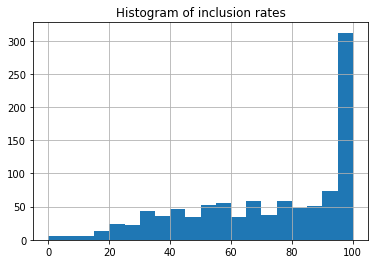

-- Mean inclusion rate 72.0746365422397
-- Median inclusion rate 77.345
--------------------------


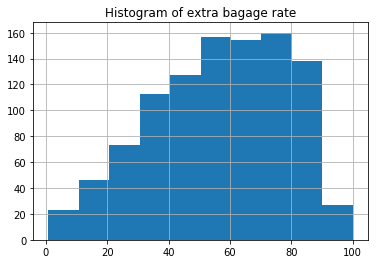

-- mean bagage rate:  56.764351669941064
-- median bagage rate:  59.05
----------------


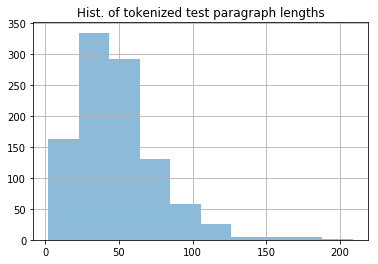

-- Mean tokenized test paragraph length  48.89489194499018
-- Median tokenized test paragraph length 44.0
-- Range of tokenized test paragraph lengths 207


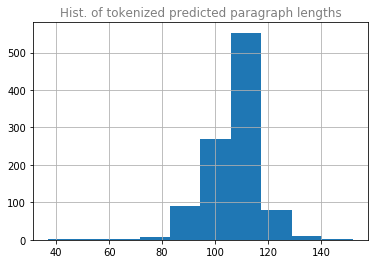

-- mean tokenized predicted parag. lenghts 107.17387033398822
-- median tokenized predicted parag. lenghts 108.0


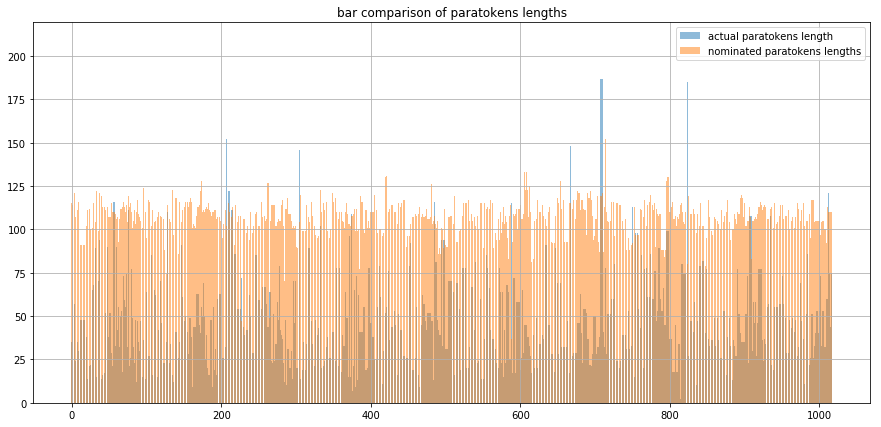

In [197]:
# report and plot the overall inclusion
print('='*30, 'Inclusion Report', '='*50)

# total inclusion rate
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')

# report inclusion_rate
plt.hist(inclusion_rates, bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()
print('-- Mean inclusion rate', np.mean(np.array(inclusion_rates)))
print('-- Median inclusion rate', np.median(np.array(inclusion_rates)))
print("--------------------------")

# report extra baggage rate
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()
print('-- mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('-- median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("----------------")

# report lengths of tokenized paragraphs
plt.hist(actual_paratokens_lengths, alpha = 0.5)
plt.title('Hist. of tokenized test paragraph lengths')
plt.grid()
plt.show()
print('-- Mean tokenized test paragraph length ', np.mean(np.array(actual_paratokens_lengths)))
print('-- Median tokenized test paragraph length', np.median(np.array(actual_paratokens_lengths)))
print('-- Range of tokenized test paragraph lengths', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of tokenized predicted paragraph lengths', alpha = 0.5)
plt.grid()
plt.show()
print('-- mean tokenized predicted parag. lenghts', np.mean(np.array(nominated_paratokens_lengths)))
print('-- median tokenized predicted parag. lenghts', np.median(np.array(nominated_paratokens_lengths)))
#print('-- range of tokenized predicted parag. lenghts', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))

# plot overlay of each paragraph's lengths
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.5,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.5,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens length', 'nominated paratokens lengths'])
plt.grid()
plt.show()

## write out the csv

In [220]:
#share_rprchs_prgrph_df.to_csv('ml_predictions_validated.csv')

# Explore results

In [214]:
#share_rprchs_prgrph_df = pd.read_csv('ml_predictions.csv')

In [215]:
share_rprchs_prgrph_df.columns

Index(['Unnamed: 0', 'ticker', 'accession_number', 'data_key_friendly_name',
       'text', 'data_value', 'reported_data_value', 'reported_units',
       'paragraph_text', 'pred_par', 'amount', 'authorization', 'date',
       'count', 'intention', 'utilization', 'unknown', 'pred_proba'],
      dtype='object')

In [216]:
share_rprchs_prgrph_df['tknzd_tst_par_len'] = np.nan

#share_rprchs_prgrph_df['pred_proba'] = np.nan

share_rprchs_prgrph_df['tot_incl'] = np.nan
share_rprchs_prgrph_df['inclusion_pct'] = np.nan
share_rprchs_prgrph_df['baggage_pct'] = np.nan
share_rprchs_prgrph_df['tknzd_pred_par_len'] = np.nan

In [206]:
share_rprchs_prgrph_df.columns

Index(['Unnamed: 0', 'ticker', 'accession_number', 'data_key_friendly_name',
       'text', 'data_value', 'reported_data_value', 'reported_units',
       'paragraph_text', 'pred_par', 'amount', 'authorization', 'date',
       'count', 'intention', 'utilization', 'unknown', 'pred_proba',
       'tknzd_tst_par_len', 'tot_incl', 'inclusion_pct', 'baggage_pct',
       'tknzd_pred_par_len'],
      dtype='object')

## populate the validation columns

In [219]:
for i in share_rprchs_prgrph_df.index:
    ti = datetime.datetime.now()
    incl_dct = measure_inclusion(share_rprchs_prgrph_df.pred_par[i], share_rprchs_prgrph_df.paragraph_text[i])
    
    share_rprchs_prgrph_df.tknzd_tst_par_len[i] = incl_dct['test_tokenized_par_len']
    share_rprchs_prgrph_df.tot_incl[i] = incl_dct['total_inclusion']
    share_rprchs_prgrph_df.inclusion_pct[i] = incl_dct['inclusion_pct']
    share_rprchs_prgrph_df.baggage_pct[i] = incl_dct['baggage_pct']
    share_rprchs_prgrph_df.tknzd_pred_par_len[i] = incl_dct['pred_tokenized_par_len']
    tf = datetime.datetime.now()
    print('assigned row', i, 'iteration took', tf - ti)
    

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: 

assigned row 0 iteration took 0:00:00.509418
assigned row 1 iteration took 0:00:00.517758
assigned row 2 iteration took 0:00:00.478333
assigned row 3 iteration took 0:00:00.491141
assigned row 4 iteration took 0:00:00.542598
assigned row 5 iteration took 0:00:00.526418
assigned row 6 iteration took 0:00:00.501907
assigned row 7 iteration took 0:00:00.563677
assigned row 8 iteration took 0:00:00.491416
assigned row 9 iteration took 0:00:00.515993
assigned row 10 iteration took 0:00:00.484717
assigned row 11 iteration took 0:00:00.466027
assigned row 12 iteration took 0:00:00.477559
assigned row 13 iteration took 0:00:00.475636
assigned row 14 iteration took 0:00:00.461170
assigned row 15 iteration took 0:00:00.466199
assigned row 16 iteration took 0:00:00.483345
assigned row 17 iteration took 0:00:00.448587
assigned row 18 iteration took 0:00:00.487826
assigned row 19 iteration took 0:00:00.451790
assigned row 20 iteration took 0:00:00.470630
assigned row 21 iteration took 0:00:00.46281

assigned row 177 iteration took 0:00:00.494316
assigned row 178 iteration took 0:00:00.468535
assigned row 179 iteration took 0:00:00.490355
assigned row 180 iteration took 0:00:00.475360
assigned row 181 iteration took 0:00:00.467411
assigned row 182 iteration took 0:00:00.458548
assigned row 183 iteration took 0:00:00.485053
assigned row 184 iteration took 0:00:00.478855
assigned row 185 iteration took 0:00:00.460819
assigned row 186 iteration took 0:00:00.486641
assigned row 187 iteration took 0:00:00.479942
assigned row 188 iteration took 0:00:00.399653
assigned row 189 iteration took 0:00:00.370924
assigned row 190 iteration took 0:00:00.364206
assigned row 191 iteration took 0:00:00.447084
assigned row 192 iteration took 0:00:00.465148
assigned row 193 iteration took 0:00:00.469513
assigned row 194 iteration took 0:00:00.458625
assigned row 195 iteration took 0:00:00.464559
assigned row 196 iteration took 0:00:00.475833
assigned row 197 iteration took 0:00:00.484860
assigned row 

assigned row 352 iteration took 0:00:00.467141
assigned row 353 iteration took 0:00:00.484174
assigned row 354 iteration took 0:00:00.455073
assigned row 355 iteration took 0:00:00.458467
assigned row 356 iteration took 0:00:00.462146
assigned row 357 iteration took 0:00:00.457738
assigned row 358 iteration took 0:00:00.456078
assigned row 359 iteration took 0:00:00.458482
assigned row 360 iteration took 0:00:00.474150
assigned row 361 iteration took 0:00:00.455491
assigned row 362 iteration took 0:00:00.473898
assigned row 363 iteration took 0:00:00.473860
assigned row 364 iteration took 0:00:00.463163
assigned row 365 iteration took 0:00:00.480436
assigned row 366 iteration took 0:00:00.466727
assigned row 367 iteration took 0:00:00.460021
assigned row 368 iteration took 0:00:00.450859
assigned row 369 iteration took 0:00:00.466138
assigned row 370 iteration took 0:00:00.464210
assigned row 371 iteration took 0:00:00.460149
assigned row 372 iteration took 0:00:00.456919
assigned row 

assigned row 527 iteration took 0:00:00.461555
assigned row 528 iteration took 0:00:00.462514
assigned row 529 iteration took 0:00:00.468120
assigned row 530 iteration took 0:00:00.447795
assigned row 531 iteration took 0:00:00.463527
assigned row 532 iteration took 0:00:00.462498
assigned row 533 iteration took 0:00:00.480732
assigned row 534 iteration took 0:00:00.463052
assigned row 535 iteration took 0:00:00.478862
assigned row 536 iteration took 0:00:00.453663
assigned row 537 iteration took 0:00:00.471416
assigned row 538 iteration took 0:00:00.471489
assigned row 539 iteration took 0:00:00.462781
assigned row 540 iteration took 0:00:00.458288
assigned row 541 iteration took 0:00:00.458029
assigned row 542 iteration took 0:00:00.468449
assigned row 543 iteration took 0:00:00.459491
assigned row 544 iteration took 0:00:00.463557
assigned row 545 iteration took 0:00:00.464783
assigned row 546 iteration took 0:00:00.470282
assigned row 547 iteration took 0:00:00.472824
assigned row 

assigned row 702 iteration took 0:00:00.459519
assigned row 703 iteration took 0:00:00.468387
assigned row 704 iteration took 0:00:00.466937
assigned row 705 iteration took 0:00:00.460862
assigned row 706 iteration took 0:00:00.450767
assigned row 707 iteration took 0:00:00.455911
assigned row 708 iteration took 0:00:00.464631
assigned row 709 iteration took 0:00:00.461039
assigned row 710 iteration took 0:00:00.477993
assigned row 711 iteration took 0:00:00.470156
assigned row 712 iteration took 0:00:00.463315
assigned row 713 iteration took 0:00:00.474170
assigned row 714 iteration took 0:00:00.463240
assigned row 715 iteration took 0:00:00.474291
assigned row 716 iteration took 0:00:00.476029
assigned row 717 iteration took 0:00:00.463948
assigned row 718 iteration took 0:00:00.457345
assigned row 719 iteration took 0:00:00.462354
assigned row 720 iteration took 0:00:00.451087
assigned row 721 iteration took 0:00:00.477359
assigned row 722 iteration took 0:00:00.467170
assigned row 

assigned row 877 iteration took 0:00:00.513195
assigned row 878 iteration took 0:00:00.497405
assigned row 879 iteration took 0:00:00.475878
assigned row 880 iteration took 0:00:00.501281
assigned row 881 iteration took 0:00:00.487638
assigned row 882 iteration took 0:00:00.472913
assigned row 883 iteration took 0:00:00.461020
assigned row 884 iteration took 0:00:00.469740
assigned row 885 iteration took 0:00:00.487266
assigned row 886 iteration took 0:00:00.486674
assigned row 887 iteration took 0:00:00.501680
assigned row 888 iteration took 0:00:00.484546
assigned row 889 iteration took 0:00:00.480590
assigned row 890 iteration took 0:00:00.473000
assigned row 891 iteration took 0:00:00.483562
assigned row 892 iteration took 0:00:00.473970
assigned row 893 iteration took 0:00:00.479612
assigned row 894 iteration took 0:00:00.467754
assigned row 895 iteration took 0:00:00.454973
assigned row 896 iteration took 0:00:00.463414
assigned row 897 iteration took 0:00:00.464559
assigned row 

assigned row 1051 iteration took 0:00:00.474142
assigned row 1052 iteration took 0:00:00.460415
assigned row 1053 iteration took 0:00:00.403387
assigned row 1054 iteration took 0:00:00.369274
assigned row 1055 iteration took 0:00:00.500868
assigned row 1056 iteration took 0:00:00.483169
assigned row 1057 iteration took 0:00:01.021681
assigned row 1058 iteration took 0:00:01.194888
assigned row 1059 iteration took 0:00:00.985310
assigned row 1060 iteration took 0:00:00.652330
assigned row 1061 iteration took 0:00:00.619362
assigned row 1062 iteration took 0:00:00.508700
assigned row 1063 iteration took 0:00:00.472958
assigned row 1064 iteration took 0:00:00.479369
assigned row 1065 iteration took 0:00:00.479732
assigned row 1066 iteration took 0:00:00.468217
assigned row 1067 iteration took 0:00:00.470257
assigned row 1068 iteration took 0:00:00.450112
assigned row 1069 iteration took 0:00:00.465543
assigned row 1070 iteration took 0:00:00.459740
assigned row 1071 iteration took 0:00:00

assigned row 1222 iteration took 0:00:00.457539
assigned row 1223 iteration took 0:00:00.489042
assigned row 1224 iteration took 0:00:00.479799
assigned row 1225 iteration took 0:00:00.476082
assigned row 1226 iteration took 0:00:00.476036
assigned row 1227 iteration took 0:00:00.487175
assigned row 1228 iteration took 0:00:00.475533
assigned row 1229 iteration took 0:00:00.450095
assigned row 1230 iteration took 0:00:00.470403
assigned row 1231 iteration took 0:00:00.466587
assigned row 1232 iteration took 0:00:00.480742
assigned row 1233 iteration took 0:00:00.492298
assigned row 1234 iteration took 0:00:00.497572
assigned row 1235 iteration took 0:00:00.491848
assigned row 1236 iteration took 0:00:00.502861
assigned row 1237 iteration took 0:00:00.502429
assigned row 1238 iteration took 0:00:00.531324
assigned row 1239 iteration took 0:00:00.501252
assigned row 1240 iteration took 0:00:00.478233
assigned row 1241 iteration took 0:00:00.492484
assigned row 1242 iteration took 0:00:00

assigned row 1393 iteration took 0:00:00.469690
assigned row 1394 iteration took 0:00:00.485660
assigned row 1395 iteration took 0:00:00.486406
assigned row 1396 iteration took 0:00:00.475103
assigned row 1397 iteration took 0:00:00.465456
assigned row 1398 iteration took 0:00:00.463503
assigned row 1399 iteration took 0:00:00.457112
assigned row 1400 iteration took 0:00:00.453885
assigned row 1401 iteration took 0:00:00.456134
assigned row 1402 iteration took 0:00:00.481839
assigned row 1403 iteration took 0:00:00.485669
assigned row 1404 iteration took 0:00:00.486438
assigned row 1405 iteration took 0:00:00.507215
assigned row 1406 iteration took 0:00:00.495174
assigned row 1407 iteration took 0:00:00.489215
assigned row 1408 iteration took 0:00:00.561302
assigned row 1409 iteration took 0:00:00.590955
assigned row 1410 iteration took 0:00:00.586546
assigned row 1411 iteration took 0:00:00.588846
assigned row 1412 iteration took 0:00:00.551848
assigned row 1413 iteration took 0:00:00

assigned row 1564 iteration took 0:00:00.537804
assigned row 1565 iteration took 0:00:00.529025
assigned row 1566 iteration took 0:00:00.553593
assigned row 1567 iteration took 0:00:00.540886
assigned row 1568 iteration took 0:00:00.588489
assigned row 1569 iteration took 0:00:00.566492
assigned row 1570 iteration took 0:00:00.545431
assigned row 1571 iteration took 0:00:00.553859
assigned row 1572 iteration took 0:00:00.495122
assigned row 1573 iteration took 0:00:00.492063
assigned row 1574 iteration took 0:00:00.494024
assigned row 1575 iteration took 0:00:00.561773
assigned row 1576 iteration took 0:00:00.552575
assigned row 1577 iteration took 0:00:00.518273
assigned row 1578 iteration took 0:00:00.482456
assigned row 1579 iteration took 0:00:00.482631
assigned row 1580 iteration took 0:00:00.482565
assigned row 1581 iteration took 0:00:00.490078
assigned row 1582 iteration took 0:00:00.471557
assigned row 1583 iteration took 0:00:00.476661
assigned row 1584 iteration took 0:00:00

assigned row 1735 iteration took 0:00:00.546648
assigned row 1736 iteration took 0:00:00.512154
assigned row 1737 iteration took 0:00:00.511091
assigned row 1738 iteration took 0:00:00.504035
assigned row 1739 iteration took 0:00:00.530110
assigned row 1740 iteration took 0:00:00.494353
assigned row 1741 iteration took 0:00:00.481556
assigned row 1742 iteration took 0:00:00.484543
assigned row 1743 iteration took 0:00:00.471821
assigned row 1744 iteration took 0:00:00.459185
assigned row 1745 iteration took 0:00:00.463262
assigned row 1746 iteration took 0:00:00.463322
assigned row 1747 iteration took 0:00:00.484177
assigned row 1748 iteration took 0:00:00.489317
assigned row 1749 iteration took 0:00:00.536972
assigned row 1750 iteration took 0:00:00.456197
assigned row 1751 iteration took 0:00:00.462990
assigned row 1752 iteration took 0:00:00.455488
assigned row 1753 iteration took 0:00:00.472900
assigned row 1754 iteration took 0:00:00.482707
assigned row 1755 iteration took 0:00:00

In [222]:
share_rprchs_prgrph_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1772 entries, 0 to 1771
Data columns (total 23 columns):
Unnamed: 0                1772 non-null int64
ticker                    1772 non-null object
accession_number          1772 non-null object
data_key_friendly_name    1772 non-null object
text                      1772 non-null object
data_value                1772 non-null int64
reported_data_value       1772 non-null float64
reported_units            1772 non-null object
paragraph_text            1772 non-null object
pred_par                  1772 non-null object
amount                    1772 non-null int64
authorization             1772 non-null int64
date                      1772 non-null int64
count                     1772 non-null int64
intention                 1772 non-null int64
utilization               1772 non-null int64
unknown                   1772 non-null int64
pred_proba                1772 non-null float64
tknzd_tst_par_len         1772 non-null float64
tot_in

In [221]:
 share_rprchs_prgrph_df.head()

,Unnamed: 0,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text,pred_par,...,count,intention,utilization,unknown,pred_proba,tknzd_tst_par_len,tot_incl,inclusion_pct,baggage_pct,tknzd_pred_par_len
0,0,A,0001090872-17-000018,Share Repurchase Authorization Date,"May 28, 2015",20150528,20200000.00,ones,"On May 28, 2015 we announced that our board ...","ases under this authorization. on may 28, 2015...",...,0,0,0,0,0.975636,46.0,False,97.83,40.00,[pred_tokenized_par_len]
1,1,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ...","31, 2016 we repurchased approximately 2.4 mil...",...,0,0,0,0,0.988679,46.0,False,97.83,40.91,[pred_tokenized_par_len]
2,2,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ...","zation. on may 28, 2015 we announced that our ...",...,0,1,0,0,0.999220,38.0,False,94.74,47.27,[pred_tokenized_par_len]
3,3,A,0001090872-17-000018,Share Repurchase Count,repurchased,4100000,4.10,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,...,1,0,0,0,0.994602,38.0,False,94.74,46.36,[pred_tokenized_par_len]
4,4,A,0001090872-17-000018,Amount Spent on Share Repurchases,repurchased,194000000,194.00,millions,"Table of Contents 2016, upon the completion ...",ed the purchases under this authorization. on ...,...,0,0,0,0,0.991570,38.0,False,94.74,46.36,[pred_tokenized_par_len]


In [169]:
for i in range(len(share_rprchs_prgrph_df.paragraph_text)):
    if share_rprchs_prgrph_df.pred_par[i] != None:
        print('----------- actual paragraph ------------------')
        print(share_rprchs_prgrph_df.paragraph_text[i])
        print('-'*70)
        print('------------ predicted paragraph ---------------')
        print(share_rprchs_prgrph_df.pred_par[i])
        print('---------- inclusion rate --------------------')
        print(measure_inclusion(share_rprchs_prgrph_df.pred_par[i], share_rprchs_prgrph_df.paragraph_text[i]))
        print("="*90)

----------- actual paragraph ------------------
On May 28, 2015 we  announced that our board  of directors had approved a  new share repurchase program  (the   "2015 repurchase program"). The 2015 share repurchase program authorizes the purchase of up to $1.14  billion   of our common stock at the company's discretion  through and including November 1, 2018. The 2015  repurchase   program does  not require  the company  to  acquire a  specific number  of  shares and  may be  suspended  or   discontinued at any time. During the year ended October 31,                                                        95
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 31, 2016 we repurchased approximately 2.4 million shares for $98 million which completed the purchases under this authorization. on may 28, 2015 we announced that our board of directors had approved a new share repurchase program (the "2015 repurchase program"). th

{'total_inclusion': False, 'inclusion_pct': 90.91, 'baggage_pct': 22.81, 'pred_tokenized_par_len': 114, 'test_tokenized_par_len': 44}
----------- actual paragraph ------------------
Stock Repurchase Program   To facilitate  our stock  repurchase program,  designed  to return  value to  our stockholders  and  minimize   dilution from  stock  issuances, we  may  repurchase shares  in  the open  market  or enter  into  structured   repurchase agreements with  third parties.  In January  2017, our  Board of  Directors approved  a new  stock   repurchase program granting us authority to repurchase up to $2.5 billion in common stock through the end  of   fiscal 2019. The new stock repurchase program approved by  our Board of Directors is similar to our  previous   stock repurchase programs
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ded from the computation of earnings per share. as of december 1, 2017, $101.5 millio

{'total_inclusion': False, 'inclusion_pct': 37.14, 'baggage_pct': 64.96, 'pred_tokenized_par_len': 117, 'test_tokenized_par_len': 70}
----------- actual paragraph ------------------
Shares purchased pursuant to the November 14, 2016 publicly announced share repurchase authorization of   (1) up to $600.0 of outstanding common stock
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 under the adc plan are intended to be fully compliant with the jobs act definition of eligible compensation and distribution requirements. 19. stock repurchase during the year ended december 31, 2017, the company repurchased 3,933,209 shares of the company's outstanding common stock at a cost of $389.5 million, exclusive of commissions, leaving $293.4 million remaining under the total repurchase authorization at december 31, 2017 (considering the november 2016 and previous authorizations). during the years ended december 31, 2016 and 2015, 

{'total_inclusion': False, 'inclusion_pct': 90.0, 'baggage_pct': 49.59, 'pred_tokenized_par_len': 121, 'test_tokenized_par_len': 40}
----------- actual paragraph ------------------
Share Repurchases   In November 2012, our Board of Directors authorized a share repurchase program. The repurchase program does   not have an expiration date, and we are not obligated to acquire a particular number of shares. The   repurchase program may be discontinued at any time at the Company's discretion. In February 2017, our Board   of Directors authorized the future acquisition of shares with an aggregate value of up to $1,000.0 under the   repurchase program, which superseded all prior repurchase programs. Under the program, we repurchased 4.0 and   3.1 shares of our common stock at a cost of $463.6 and $430.6 during the years ended December 31, 2017 and   2016, respectively
----------------------------------------------------------------------
------------ predicted paragraph ---------------
rred $

{'total_inclusion': False, 'inclusion_pct': 83.33, 'baggage_pct': 65.52, 'pred_tokenized_par_len': 116, 'test_tokenized_par_len': 24}
----------- actual paragraph ------------------
As of December 31, 2017, $4.4 billion remained available under our stock repurchase program. In January 2018,   our Board of Directors authorized an additional $10.0 billion under our stock repurchase program. On February   5, 2018, we announced  a tender offer  to purchase up  to $10.0 billion of  our common stock  at a price  not   greater than $200 per share  nor less than $175  per share. The tender offer  expires at 12:00 Midnight,  New   York City time, at the end of Monday, March 5, 2018, unless the offer is extended
----------------------------------------------------------------------
------------ predicted paragraph ---------------
es may also be affected by the stock price and blackout periods, during which we are restricted from repurchasing stock. the manner of stock repurchases may include pri

{'total_inclusion': False, 'inclusion_pct': 90.74, 'baggage_pct': 34.29, 'pred_tokenized_par_len': 105, 'test_tokenized_par_len': 54}
----------- actual paragraph ------------------
Table of Contents                                    AMERICAN TOWER CORPORATION AND SUBSIDIARIES                                    NOTES TO CONSOLIDATED FINANCIAL STATEMENTS                             (Tabular amounts in millions, unless otherwise disclosed)   Stock Repurchase Programs-In March 2011, the Company's Board of Directors approved a stock repurchase   program, pursuant to which the Company is authorized to repurchase up to $1.5 billion of its common stock   (the "2011 Buyback"). In December 2017, the Board of Directors approved an additional stock repurchase   program, pursuant to which the Company is authorized to repurchase up to $2.0 billion of its common stock   (the "2017 Buyback")
----------------------------------------------------------------------
------------ predicted paragraph -----

{'total_inclusion': False, 'inclusion_pct': 95.77, 'baggage_pct': 35.14, 'pred_tokenized_par_len': 111, 'test_tokenized_par_len': 71}
----------- actual paragraph ------------------
On February 2, 2017, our Board of Directors authorized a stock repurchase program under which we are   authorized to repurchase up to $1 billion of our common stock during the two-year period from February 13,   2017 through February 12, 2019. As of the date hereof, we have not repurchased any shares under this program   and the determination as to if and when we make any such stock repurchases will be dependent on market   conditions and other factors
----------------------------------------------------------------------
------------ predicted paragraph ---------------
e 1 million, 5 million, and 1 million shares of common stock were not included in the calculation of diluted earnings per common share for the years ended december 31, 2017, 2016, and 2015, respectively, as the effect of their inclusion woul

{'total_inclusion': False, 'inclusion_pct': 37.5, 'baggage_pct': 80.87, 'pred_tokenized_par_len': 115, 'test_tokenized_par_len': 32}
----------- actual paragraph ------------------
On June 28,  2017, following  the Federal  Reserve's non-objection  to the  Corporation's 2017  Comprehensive   Capital Analysis and Review (CCAR) capital plan, the Board of Directors (Board) authorized the repurchase  of   $12.0 billion of  common stock  from July 1,  2017 through  June 30, 2018,  plus repurchases  expected to  be   approximately $900 million to offset  the effect of equity-based compensation  plans during the same  period
----------------------------------------------------------------------
------------ predicted paragraph ---------------
2.0 billion in common stock from july 1, 2017 through june 30, 2018, plus repurchases expected to be approximately $900 million to offset the effect of equity-based compensation plans during the same period. on december 5, 2017, following approval by the

{'total_inclusion': False, 'inclusion_pct': 71.43, 'baggage_pct': 51.69, 'pred_tokenized_par_len': 118, 'test_tokenized_par_len': 49}
----------- actual paragraph ------------------
On November 2, 2017, our board of directors authorized BHGE LLC to repurchase up to $3 billion of its        common units from the Company and GE. The proceeds of this repurchase are to be used by BHGE to        repurchase Class A common stock of the Company on the open market, which if fully implemented would        result in the repurchase of approximately $1.1 billion of Class A common stock. The Class B common stock        of the Company, that is paired with repurchased common units, was repurchased by the Company at par        value. The $3 billion repurchase authorization is the aggregate authorization for repurchases of Class A        and Class B common stock together with its paired unit. BHGE LLC had authorization remaining to   ^(2) repurchase up to approximately $2.5 billion of its common units f

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 18.87, 'pred_tokenized_par_len': 106, 'test_tokenized_par_len': 67}
----------- actual paragraph ------------------
In the first quarter of 2016, the Company's Board of Directors authorized a program to repurchase up to $3.0   billion of the Company's common stock. In the first quarter of 2017, the Company's Board of Directors   authorized an additional program to repurchase up to $2.0 billion of the Company's common stock. As of   December 31, 2017, the Company had a remaining authorization of $2.4 billion to purchase its common stock. In   the first quarter of 2018, the Company's Board of Directors authorized an additional program to repurchase up   to $8.0 billion of the Company's common stock. The Company may make repurchases of shares under its stock   repurchase programs, depending on prevailing market conditions, alternate uses of capital and other factors
-----------------------------------------------------------

{'total_inclusion': False, 'inclusion_pct': 79.63, 'baggage_pct': 60.0, 'pred_tokenized_par_len': 115, 'test_tokenized_par_len': 54}
----------- actual paragraph ------------------
Represents repurchases under the $15.6 billion 2017 common stock repurchase program (2017 Repurchase       Program) that was approved by Citigroup's Board of Directors and announced on June 28, 2017. The 2017       Repurchase Program was part of the planned capital actions included by Citi in its 2017 Comprehensive       Capital Analysis and Review (CCAR). Shares repurchased under the 2017 Repurchase Program were added to   (1) treasury stock
----------------------------------------------------------------------
------------ predicted paragraph ---------------
entirely of common stock repurchases, during the three months ended december 31, 2017: in millions, except per share amounts total shares purchased average price paid per share approximate dollar value of shares that may yet be purchased under the plan

{'total_inclusion': False, 'inclusion_pct': 85.19, 'baggage_pct': 40.74, 'pred_tokenized_par_len': 108, 'test_tokenized_par_len': 54}
----------- actual paragraph ------------------
Share Repurchases   During fiscal  2017, we  repurchased  $600 million  of our  common  shares. We  funded the  repurchases  with   available cash.  At June  30, 2017,  we had  $443 million  remaining under  our existing  $1.0 billion  share   repurchase program
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 june 30, 2016 87.20 73.69 0.4489 fiscal 2017 quarter ended: september 30, 2016 $ 84.92 $ 75.26 $ 0.4489 december 31, 2016 76.71 65.17 0.4489 march 31, 2017 83.80 72.47 0.4489 june 30, 2017 82.71 71.18 0.4624 fiscal 2018 $ 78.69 $ 76.29 $ - at july 31, 2017 there were approximately 8,239 shareholders of record of our common shares. we anticipate that we will continue to pay quarterly cash dividends in the future. the payment and am

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 27.72, 'pred_tokenized_par_len': 101, 'test_tokenized_par_len': 56}
----------- actual paragraph ------------------
NOTE 9 - Shareholders' Equity   Under a share repurchase program effective 2004, we are authorized to repurchase Carnival Corporation common   stock and Carnival plc ordinary shares (the "Repurchase Program"). On April 6, 2017, the Boards of Directors   approved a modification of the general authorization under the Repurchase Program, which replenished the   remaining authorized repurchases at the time of the approval to $1.0 billion. The Repurchase Program does not   have an expiration date and may be discontinued by our Boards of Directors at any time
----------------------------------------------------------------------
------------ predicted paragraph ---------------
o $1.0 billion. the repurchase program does not have an expiration date and may be discontinued by our boards of directors at any time. dur

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 56.98, 'pred_tokenized_par_len': 86, 'test_tokenized_par_len': 22}
----------- actual paragraph ------------------
Stock Repurchases   On February 19, 2015, the Board authorized the repurchase of shares of the Company's common stock having an   aggregate purchase price of up to $5,000 under a share repurchase program (the "2015 Program"), which   replaced a previously authorized share repurchase program. The Company commenced repurchase of shares of the   Company's common stock under the 2015 Program beginning February 19, 2015. The Board also has authorized   share repurchases on an ongoing basis to fulfill certain requirements of the Company's compensation and   benefit programs. The shares are repurchased from time to time in open market or privately negotiated   transactions at the Company's discretion, subject to market conditions, customary blackout periods and other   factors. The Company repurchased its common st

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 67.59, 'pred_tokenized_par_len': 108, 'test_tokenized_par_len': 16}
----------- actual paragraph ------------------
Share Repurchases   In December 2011, our Board of Directors authorized the 2012 Share Repurchase Program and through  subsequent   amendments, the most  recent in  March 2017,  the total repurchase  authorization was  increased from  $500.0   million to  $1.0 billion  of the  Company's common  stock. The  program has  no expiration  date and  may  be   discontinued at any time. Purchases under  the 2012 Share Repurchase Program are  subject to a review of  the   circumstances in place at  the time and may  be made from time  to time as permitted  by securities laws  and   other legal requirements
----------------------------------------------------------------------
------------ predicted paragraph ---------------
nded and approved by the company's board of directors for an increase of $500.0 million, prov

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 58.97, 'pred_tokenized_par_len': 117, 'test_tokenized_par_len': 29}
----------- actual paragraph ------------------
In September 2001, the  Company's Board of Directors  authorized a stock repurchase  program. As of July  29,   2017, the Company's Board of Directors had authorized an aggregate repurchase of up to $112 billion of common   stock under  this  program, and  the  remaining  authorized repurchase  amount  was $11.7  billion,  with  no   termination date. A summary  of the stock  repurchase activity under the  stock repurchase program,  reported   based on the trade date, is summarized as follows (in millions, except per-share amounts):
----------------------------------------------------------------------
------------ predicted paragraph ---------------
quarter $ 34.53 $ 30.42 $ 28.70 $ 22.46 fourth quarter $ 34.60 $ 30.37 $ 31.15 $ 25.81 (b) not applicable. (c) issuer purchases of equity securities (in million

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 20.41, 'pred_tokenized_par_len': 98, 'test_tokenized_par_len': 69}
----------- actual paragraph ------------------
As of  December 31,  2017, the  Company's Board  authorized a  total aggregate  share repurchase  plan of  $5   billion. The following table  shows the shares repurchased  and retired during the  years ended December  31,   2017, 2016 and 2015:
----------------------------------------------------------------------
------------ predicted paragraph ---------------
tain forfeitable rights to dividends and deus. because the deus are forfeitable, they are defined as non-participating securities. as of december 31, 2017, there were 53,689 deus, which will vest at the time that the underlying rsu and psu vests. as of december 31, 2017, the company's board authorized a total aggregate share repurchase plan of $5 billion. the following table shows the shares repurchased and retired during the years ended december 31,

{'total_inclusion': False, 'inclusion_pct': 83.56, 'baggage_pct': 27.68, 'pred_tokenized_par_len': 112, 'test_tokenized_par_len': 73}
----------- actual paragraph ------------------
In February 2014, the Company's Board of Directors authorized repurchase of up to $1 billion of the Company's   outstanding common stock at such times, in such amounts, and on such terms, as determined by management to be   in the best interests of the Company. As of December 31, 2017, a total of 10,726,827 shares have been   repurchased under this authorization for a total of $848 million. During 2017, the Company repurchased   4,184,637 shares of common stock for a cost of approximately $350 million. During 2016, the Company   repurchased 2,131,501 shares of common stock for a cost of approximately $145 million. During 2015, the   Company repurchased 1,477,660 shares of common stock for a cost of approximately $103 million
----------------------------------------------------------------------
------------

{'total_inclusion': False, 'inclusion_pct': 56.38, 'baggage_pct': 64.44, 'pred_tokenized_par_len': 90, 'test_tokenized_par_len': 94}
----------- actual paragraph ------------------
In October 2010 the Board granted authority for a  $500 million share repurchase program. As of December  31,   2017, $350 million of authority remains under the $500 million share repurchase program
----------------------------------------------------------------------
------------ predicted paragraph ---------------
69.63 79.72 65.38 second 80.61 74.88 81.36 72.67 third 80.49 74.83 82.09 75.99 fourth 87.95 75.01 76.56 66.71 consecutive quarterly cash dividends on common stock were paid to stockholders of entergy corporation in 2017 and 2016. quarterly dividends of $0.85 per share were paid through third quarter 2016. in fourth quarter 2016 and through third quarter 2017, dividends of $0.87 per share were paid. in fourth quarter 2017, dividends of $0.89 per share were paid. as of january 31, 2018, there wer

{'total_inclusion': False, 'inclusion_pct': 95.77, 'baggage_pct': 22.81, 'pred_tokenized_par_len': 114, 'test_tokenized_par_len': 71}
----------- actual paragraph ------------------
Common Stock Repurchase   On April 20, 2016, the Company announced that its Board of Directors authorized an additional $1.0 billion   for its common stock share repurchase program. This new authorization is incremental to the existing $2.4   billion program, initially approved in October 2010 and expanded in each fiscal year. Acquisitions for the   share repurchase programs will be made from time to time in private transactions or open market purchases as   permitted by securities laws and other legal requirements. The programs can be terminated at any time. During   fiscal year 2017, the Company repurchased and retired 4,561,213 shares at an average price of $131.56 per   share and as of September 30, 2017, the Company had $173.7 million remaining authorized to purchase shares
----------------------------

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 33.33, 'pred_tokenized_par_len': 117, 'test_tokenized_par_len': 55}
----------- actual paragraph ------------------
On July 15, 2015, Corning's Board of Directors approved a $2 billion share repurchase program (the "July 2015   Repurchase Program") and on October 26, 2015 the Board of Directors authorized an additional $4 billion share   repurchase program (together with the July 2015 Repurchase Program, the "2015 Repurchase Programs"). The 2015   Repurchase Programs permit Corning to effect repurchases from time to time through a combination of open   market repurchases, privately negotiated transactions, advance repurchase agreements and/or other   arrangements
----------------------------------------------------------------------
------------ predicted paragraph ---------------
" options exercisable on december 31, 2017, was approximately 13 million. ﻿ the weighted-average grant-date fair value for options granted for 

{'total_inclusion': False, 'inclusion_pct': 68.09, 'baggage_pct': 56.67, 'pred_tokenized_par_len': 120, 'test_tokenized_par_len': 47}
----------- actual paragraph ------------------
Common Stock Repurchases   On September 18, 2013,  the Board of  Directors approved our  common stock repurchase  program. From time  to   time, the Board  of Directors has  approved increases  in the amount  authorized to be  purchased under  that   program. On February 2,  2017, the Board of  Directors approved a further  increase in that authorization  to   $2.1 billion. This program expires on  December 31, 2019. We intend to  repurchase shares of common stock  in   open market transactions  in order  to offset new  shares issued  under equity compensation  programs and  to   provide for additional  shareholder returns.  During 2017,  we repurchased  12,755,547 shares  at an  average   price, including  commissions,  of $31.37  per  share, or  $400  million in  the  aggregate. Since  2013,  we   repurch

----------------------------------------------------------------------
------------ predicted paragraph ---------------
 employee benefit plans 54 note 10. weighted average common shares 55 note 11. commitments and contingencies 55 note 12. interline acquisition 56 note 13. investment in hd supply 56 note 14. quarterly financial data (unaudited) 56 29 table of contents report of independent registered public accounting firm the stockholders and board of directors the home depot, inc.: opinion on the consolidated financial statements we have audited the accompanying consolidated balance sheets of the home depot, inc. and subsidiaries as of january 28, 2018 and january 29, 2017, and the related consolidated statements of earnings, comprehensive income, stockholders' equity, and cash flows for each of the fiscal years in the three-year period ended january 28, 2018 and the related notes (collectively, the "consolidated financial statements"). in our opinion, the consolidated financial sta

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 48.6, 'pred_tokenized_par_len': 107, 'test_tokenized_par_len': 42}
----------- actual paragraph ------------------
On June 21, 2016, the Company's Board of Directors authorized the repurchase of up to an additional $500.0   million of the Company's outstanding common stock over the next five years. There were no repurchases of   common stock made under                                                       F-43
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ed and paid refund claims submitted in connection with medical device excise tax filings for the january 1, 2013 through december 31, 2015 periods. as a result, the company recorded a $12.4 million gain in fiscal 2017 within general and administrative expenses. 8. stockholders' equity and stock-based compensation stock repurchase program on november 11, 2013, the company announced that its board of

{'total_inclusion': False, 'inclusion_pct': 70.18, 'baggage_pct': 54.17, 'pred_tokenized_par_len': 96, 'test_tokenized_par_len': 57}
----------- actual paragraph ------------------
The shares repurchased in fiscal years 2017, 2016 and 2015 were all open market repurchase transactions. As   of October 31, 2017, HP had remaining authorization of approximately $2.5 billion for future share   repurchases under the $3.0 billion repurchase authorization approved by HP's Board of Directors on October   10, 2016
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 total number of shares purchased average price paid per share total number of shares purchased as part of publicly announced plans or programs approximate dollar value of shares that may yet be purchased under the plans or programs in thousands, except per share amounts period august 2017 2,443 $ 19.10 2,443 $ 2,914,759 september 2017 5,871 $ 19.50 5,871 $ 2,800,269 

{'total_inclusion': False, 'inclusion_pct': 95.08, 'baggage_pct': 0.91, 'pred_tokenized_par_len': 110, 'test_tokenized_par_len': 122}
----------- actual paragraph ------------------
Our share repurchase program, announced on June 21, 2004, originally allowed us to repurchase up to $100   million of shares of our common stock, which represented approximately 3.5% of the shares outstanding at the   commencement of the program. As summarized in the table below, subsequent additional increases totaling $2.8   billion, authorized by our Board of Directors, to the repurchase program provide for a total of $2.9 billion   of shares of our common stock to be repurchased under this program
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 august 18, 2011 200,000,000 april 18, 2012 200,000,000 november 12, 2012 300,000,000 december 9, 2013 300,000,000 december 4, 2014 300,000,000 november 30, 2015 400,000,000 october 18, 2016 

{'total_inclusion': False, 'inclusion_pct': 36.76, 'baggage_pct': 67.8, 'pred_tokenized_par_len': 118, 'test_tokenized_par_len': 68}
----------- actual paragraph ------------------
(1)           On October 25, 2016, the Board of Directors authorized $3.0 billion in funds for use in the company's           common stock repurchase program. On October 31, 2017, the Board of Directors authorized an additional           $3.0 billion in funds for use in such program. In each case, the company stated that it would           repurchase shares on the open market or in private transactions depending on market conditions. The           common stock repurchase program does not have an expiration date. This table does not include shares           tendered to satisfy the exercise price in connection with cashless exercises of employee stock           options or shares tendered to satisfy tax withholding obligations in connection with employee equity           awards
---------------------------------

{'total_inclusion': False, 'inclusion_pct': 35.38, 'baggage_pct': 65.38, 'pred_tokenized_par_len': 104, 'test_tokenized_par_len': 130}
----------- actual paragraph ------------------
ISSUER PURCHASES OF EQUITY SECURITIES   We have an ongoing authorization, originally approved by our Board of Directors in 2005, and subsequently   amended, to repurchase shares of our common stock in open market or negotiated transactions. As of December   30, 2017, we were authorized to repurchase up to $75.0 billion, of which $13.2 billion remained available
----------------------------------------------------------------------
------------ predicted paragraph ---------------
of equity securities we have an ongoing authorization, originally approved by our board of directors in 2005, and subsequently amended, to repurchase shares of our common stock in open market or negotiated transactions. as of december 30, 2017, we were authorized to repurchase up to $75.0 billion, of which $13.2 billion remained av

{'total_inclusion': False, 'inclusion_pct': 56.96, 'baggage_pct': 65.0, 'pred_tokenized_par_len': 100, 'test_tokenized_par_len': 79}
----------- actual paragraph ------------------
Share repurchases are made  from time to  time in accordance with  management's capital allocation  strategy,   subject to market conditions and regulatory requirements. In February 2014, the Company's Board of  Directors   authorized the repurchase of up to $1.5 billion of our ordinary shares under a share repurchase program  that   began in April 2014. Shares repurchased prior to October 2014 were canceled upon repurchase and accounted for   as a reduction of  Ordinary shares and Capital  in excess of  par value, or Retained  earnings to the  extent   Capital in excess of  par value was  exhausted. Beginning in  October 2014, repurchased  shares were held  in   treasury and recognized at  cost. Ordinary shares held  in treasury are presented  separately on the  balance   sheet as a reduction to Equity. Thi

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 61.16, 'pred_tokenized_par_len': 121, 'test_tokenized_par_len': 41}
----------- actual paragraph ------------------
On October 22, 2015, our Board of Directors authorized  the purchase of $500 million of our common stock.  On   April 20, 2017, our Board of Directors authorized an additional purchase of up to $500 million of our  common   stock. At December 31, 2017, $521  million of the combined authorization  was remaining. We did not  purchase   any shares under our repurchase authorization during the three months ended December 31, 2017
----------------------------------------------------------------------
------------ predicted paragraph ---------------
, liquidity, earnings, capital requirements, and any other factors the board of directors may deem relevant. on january 24, 2018, we announced an increase in our quarterly cash dividend from $0.23 to $0.24 per share, which will be paid february 23, 2018, to stockholder

{'total_inclusion': False, 'inclusion_pct': 54.88, 'baggage_pct': 46.15, 'pred_tokenized_par_len': 91, 'test_tokenized_par_len': 82}
----------- actual paragraph ------------------
On June 28, 2017, in conjunction with the Federal Reserve's release of its 2017 CCAR results, the Firm's   Board of Directors authorized a $19.4 billion common equity (i.e., common stock and warrants) repurchase   program. As of December 31, 2017, $9.8 billion of authorized repurchase capacity remained under the program
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ock 5.4 million shares of its common stock as a result of these exercises. as of december 31, 2017, 15.0 million warrants remained outstanding, compared with 24.9 million outstanding as of december 31, 2016. effective june 28, 2017, the firm's board of directors authorized the repurchase of up to $19.4 billion of common equity (common stock and warrants) between july 1, 2017

{'total_inclusion': False, 'inclusion_pct': 56.0, 'baggage_pct': 84.35, 'pred_tokenized_par_len': 115, 'test_tokenized_par_len': 25}
----------- actual paragraph ------------------
Share repurchases were made pursuant to a share  repurchase program authorized by our Board of  Directors       on November 13, 2014. This  program allows for the  repurchase of 40 million shares  in an amount not  to   (a) exceed $5 billion
----------------------------------------------------------------------
------------ predicted paragraph ---------------
to time pursuant to publicly announced share repurchase programs. during 2017, we repurchased 7.2 million shares of our common stock at a cost of $900 through a broker in the open market. the following table contains information for shares repurchased during the fourth quarter of 2017. none of the shares in this table were repurchased directly from any of our officers or directors. period (2017) total number of shares purchased(a) average price paid per

{'total_inclusion': False, 'inclusion_pct': 69.7, 'baggage_pct': 75.0, 'pred_tokenized_par_len': 100, 'test_tokenized_par_len': 33}
----------- actual paragraph ------------------
In October 2010, our  Board of Directors approved  a share repurchase program  pursuant to which we  are        authorized to repurchase our common stock in privately negotiated transactions or in the open market  at        prices per share not exceeding the then-current market prices. From time to time, our Board of Directors        authorizes increases to  our share repurchase  program. On September  28, 2017, our  Board of  Directors        authorized a $2.0 billion increase to the  program. The total remaining authorization for future  common        share repurchases under our share repurchase program was $3.5 billion as of December 31, 2017. Under the        program, management has discretion to  determine the dollar amount of  shares to be repurchased and  the        timing of any  repurchases in compli

{'total_inclusion': False, 'inclusion_pct': 57.58, 'baggage_pct': 65.52, 'pred_tokenized_par_len': 116, 'test_tokenized_par_len': 33}
----------- actual paragraph ------------------
Commencing in January 2000, the Company's board of directors has from time to time approved authorizations to   purchase, in the aggregate, up to $18,000 million of Common Stock, which includes the Company's board of   directors approval of an additional authorization to purchase Common Stock of $1,500 million on February 26,   2016. All authorizations are cumulative and do not have an expiration date. During 2016, the Company   purchased approximately 7.9 million shares of Common Stock under its share repurchase program for a total of   $316 million. During 2015, the Company purchased approximately 34.8 million shares of Common Stock under its   share repurchase program for a total of $2,000 million. As of February 3, 2018, $1,716 million of   authorization remained unused. The Company may continue or, fro

{'total_inclusion': False, 'inclusion_pct': 84.62, 'baggage_pct': 46.15, 'pred_tokenized_par_len': 104, 'test_tokenized_par_len': 91}
----------- actual paragraph ------------------
Common Stock Repurchase Program   During 2017, 2016, and 2015, Mattel did not repurchase any shares of its common stock. Mattel's share   repurchase program was first announced on July 21, 2003. On July 17, 2013, the Board of Directors authorized   Mattel to increase its share repurchase program by $500.0 million. At December 31, 2017, share repurchase   authorizations of $203.0 million had not been executed. Repurchases will take place from time to time,   depending on market conditions. Mattel's share repurchase program has no expiration date
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 (608 ) 34.67 unvested at december 31 4,898 $ 21.95 3,243 $ 28.85 3,738 $ 28.98 at december 31, 2017, rsus expected to vest totaled 4.6 million sha

{'total_inclusion': False, 'inclusion_pct': 33.33, 'baggage_pct': 92.93, 'pred_tokenized_par_len': 99, 'test_tokenized_par_len': 9}
----------- actual paragraph ------------------
Between 2013 and 2017, our Board of Directors authorized the repurchase of a total of $13.7 billion of our   Common Stock through December 31, 2018. On January 31, 2018, our Finance Committee, with authorization   delegated from our Board of Directors, approved an increase of $6.0 billion in the share repurchase program,   raising the authorization to $19.7 billion of Common Stock repurchases, and extended the program through   December 31, 2020. Repurchases under the program are determined by management and are wholly discretionary
----------------------------------------------------------------------
------------ predicted paragraph ---------------
orization to $19.7 billion of common stock repurchases, and extended the program through december 31, 2020. repurchases under the program are determined by manag

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 54.05, 'pred_tokenized_par_len': 111, 'test_tokenized_par_len': 27}
----------- actual paragraph ------------------
On February 28, 2017,  the Company's Board  of Directors authorized  a new share  repurchase program for  the   purchase of up to  $500.0 million of the  Company's outstanding common stock  (the "February 2017  Repurchase   Plan"). During the year ended December 31, 2017, the Company purchased 4.6 million shares of common stock  at   an average  purchase price  of $54.91  per share,  for a  total amount  of $249.9  million (excluding  broker   commissions), under the February 2017 Repurchase Plan
----------------------------------------------------------------------
------------ predicted paragraph ---------------
time" sale prices. the source of the bid information is the nasdaq stock market, inc. we have not paid cash dividends to our stockholders since our inception and do not anticipate paying cash divi

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 46.88, 'pred_tokenized_par_len': 96, 'test_tokenized_par_len': 25}
----------- actual paragraph ------------------
Stockholders' Equity Information   Share Repurchase Program: Through a series of actions, the Board of Directors has authorized the Company to   repurchase in the aggregate up to $14.0 billion of its outstanding shares of common stock (the "share   repurchase program"). The share repurchase program does not have an expiration date. As of December 31, 2017,   the Company had used approximately $12.3 billion of the share repurchase authority, including transaction   costs, to repurchase shares, leaving $1.7 billion of authority available for future repurchases
----------------------------------------------------------------------
------------ predicted paragraph ---------------
s through open market cash purchases, privately-negotiated transactions or otherwise. such repurchases, if any, will depend on prevail

{'total_inclusion': False, 'inclusion_pct': 32.05, 'baggage_pct': 66.67, 'pred_tokenized_par_len': 117, 'test_tokenized_par_len': 78}
----------- actual paragraph ------------------
Subsequent Event - Share Repurchase Program On February 15, 2018, we announced the Company's Board of   Directors authorized a share repurchase program of $750 million which expires December 31, 2020. All   purchases will be made in accordance with applicable securities laws from time to time in open market or   private transactions, depending on market conditions, and may be discontinued at any time
----------------------------------------------------------------------
------------ predicted paragraph ---------------
following table summarizes repurchases of our common stock occurring in fourth quarter 2017: period total number of shares purchased (1) average price paid per share total number of shares purchased as part of publicly announced plans or programs approximate dollar value of shares that may yet

{'total_inclusion': False, 'inclusion_pct': 87.5, 'baggage_pct': 56.88, 'pred_tokenized_par_len': 109, 'test_tokenized_par_len': 56}
----------- actual paragraph ------------------
As of April 28, 2017, our Board of Directors has authorized the repurchase of up to $9.6 billion of our   common stock. Under this program, which we may suspend or discontinue at any time, we may purchase shares of   our outstanding common stock through open market and privately negotiated transactions at prices deemed   appropriate by our management
----------------------------------------------------------------------
------------ predicted paragraph ---------------
.3%. the weighted average fair value per share of these options was $14.32. stock repurchase program as of april 28, 2017, our board of directors has authorized the repurchase of up to $9.6 billion of our common stock. under this program, which we may suspend or discontinue at any time, we may purchase shares of our outstanding common stock thr

{'total_inclusion': False, 'inclusion_pct': 69.12, 'baggage_pct': 44.55, 'pred_tokenized_par_len': 110, 'test_tokenized_par_len': 68}
----------- actual paragraph ------------------
In July 2016, the Company announced that its Board  approved a program to repurchase up to $350.0 million  of   the Company's common stock, with authorization expiring in  May 2019 (the "July 2016 Program"). In May  2014,   the Board had previously approved a program to repurchase up to $350.0 million of the Company's common  stock   with authorization  that expired  in May  2017 (the  "May 2014  Program"). During  fiscal 2017,  the  Company   repurchased 2.9 million  shares for  $166.2 million.  Of the shares  repurchased during  fiscal 2017,  $106.5   million were repurchased under the July  2016 Program and $59.7 million  were repurchased under the May  2014   Program. During fiscal 2016, the Company repurchased 2.2 million shares for $107.9 million under the May 2014   Program. The  purpose of  both pro

{'total_inclusion': False, 'inclusion_pct': 84.76, 'baggage_pct': 20.51, 'pred_tokenized_par_len': 117, 'test_tokenized_par_len': 105}
----------- actual paragraph ------------------
Note 12. Equity   A. Common Stock   We purchase our common stock through privately negotiated transactions or in open market purchases as   circumstances and prices warrant. Purchased shares under each of the share-purchase plans, which are   authorized by our Board of Directors, are available for general corporate purposes. On June 27, 2013, we   announced that the Board of Directors had authorized a $10 billion share-purchase plan, which was exhausted   in the first quarter of 2015. On October 23, 2014, we announced that the Board of Directors had authorized an   additional $11 billion share repurchase program, which was exhausted in the first quarter of 2017. In   December 2015, the Board of Directors authorized a new $11 billion share repurchase program (the December   2015 Stock Purchase Plan) to be u

{'total_inclusion': False, 'inclusion_pct': 69.09, 'baggage_pct': 54.44, 'pred_tokenized_par_len': 90, 'test_tokenized_par_len': 55}
----------- actual paragraph ------------------
On February 25, 2016, PCA announced that its Board of Directors authorized the repurchase of $200.0 million   of the Company's outstanding common stock. Repurchases may be made from time to time in open market or   privately negotiated transactions in accordance with applicable securities regulations. The timing and amount   of repurchases will be determined by the Company in its discretion based on factors such as PCA's stock price   and market and business conditions
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 14, 2016 to shareholders of record as of september 15, 2016. during the year ended december 31, 2017, we paid $237.6 million of dividends to shareholders. on december 14, 2017 pca's board of directors approved a regular quar

{'total_inclusion': False, 'inclusion_pct': 7.5, 'baggage_pct': 86.67, 'pred_tokenized_par_len': 120, 'test_tokenized_par_len': 40}
----------- actual paragraph ------------------
Share Repurchases   In October 2015, the Board of Directors approved a share repurchase plan of up to $2.0 billion (the "2015   Authorization"). We did not repurchase any shares under the share repurchase plan during the three months   ended December 31, 2017. During the year ended December 31, 2017, we repurchased 2.7 million ordinary shares   at an average repurchase price of $71.72 per share, for a total of $191.5 million. We did not repurchase any   shares under the share repurchase plan during the year ended December 31, 2016. During the six months ended   December 31, 2015, we repurchased 3.3 million ordinary shares at an average repurchase price of $151.59 per   share, for a total of $500.0 million
----------------------------------------------------------------------
------------ predicted paragraph -

----------------------------------------------------------------------
------------ predicted paragraph ---------------
ng $0.15 per share. dividends on common stock totaled $12 million in each of 2017, 2016 and 2015. we currently project that cash dividends on our common stock in 2018 will be approximately $12 million based on our current dividend rate, the number of shares of our common stock outstanding as of february 4, 2018, our estimate of stock to be issued during 2018 under our stock incentive plans and our estimate of stock repurchases during 2018. acquisition of treasury shares our board of directors authorized a $500 million three-year stock repurchase program effective june 3, 2015. on march 21, 2017, the board of directors authorized a $750 million increase to the program and extended it to june 3, 2020. repurchases under the program may be made from time to time over the period through open market purchases, accelerated share repurchase programs, privately negotiated tran

{'total_inclusion': False, 'inclusion_pct': 85.83, 'baggage_pct': 17.86, 'pred_tokenized_par_len': 112, 'test_tokenized_par_len': 120}
----------- actual paragraph ------------------
On November 25, 2017, the Board of Directors of the Company authorized an amendment to the Share Repurchase                  Program by increasing the maximum amount from US$100 million to US$300 million
----------------------------------------------------------------------
------------ predicted paragraph ---------------
rred shares. 21. treasury shares on november 11, 2017, the board of directors of the company authorized a share repurchase program ("share repurchase program"), pursuant to which the company was authorized to repurchase its own issued and outstanding american depositary shares ("adss") up to an aggregate value of us$100 million from the open market, in negotiated transactions off the market, or through other legally permissible means in accordance with applicable securities laws from time

{'total_inclusion': False, 'inclusion_pct': 96.15, 'baggage_pct': 15.04, 'pred_tokenized_par_len': 113, 'test_tokenized_par_len': 104}
----------- actual paragraph ------------------
Common Stock. On February 21, 2014, our board of directors approved a new share repurchase program,   authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock. The program allows   us to repurchase shares of our common stock from time to time for cash in the open market, or in negotiated   or block transactions, as market and business conditions warrant and subject to applicable legal   requirements. The 20.0 million shares the new program authorizes us to purchase are in addition to the shares   we repurchased on or before February 21, 2014 under our previous programs. There is no expiration date for   this program, and the program may be accelerated, suspended, delayed or discontinued at any time at the   discretion of our board of directors. All share repurchases since Feb

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 66.34, 'pred_tokenized_par_len': 101, 'test_tokenized_par_len': 17}
----------- actual paragraph ------------------
From time to  time, our  Board of  Directors authorizes  the repurchase  of shares  of our  common stock.  In   November 2015, our Board authorized the repurchase of up to $2.0 billion of our outstanding common stock.  In   November 2017,  our  Board also  authorized  the repurchase  of  up to  an  additional $2.0  billion  of  our   outstanding common stock. At December  31, 2017, we had approximately  $2.8 billion available under the  2017   and 2015 repurchase programs. Share repurchases will take place from time to time at management's  discretion   depending on market conditions
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 due march and december 2018 at a loss of $39 million pretax, $25 million after tax, which is included in ot

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 39.42, 'pred_tokenized_par_len': 104, 'test_tokenized_par_len': 56}
----------- actual paragraph ------------------
Note 18 Stockholders' Equity   Repurchase of Common Stock   In July 2015, our Board of Directors authorized a repurchase program of up to $1.5 billion of the Company's   common stock, reflecting its commitment to return value to shareholders. The repurchase program has no   expiration date and replaced the previously authorized program, which was terminated. In March 2017, our   Board of Directors authorized an increase to the existing share repurchase program by up to an additional   $1.5 billion of the Company's common stock. Refer to Part II, Item 5., "Issuer Purchases of Equity   Securities" for further information
----------------------------------------------------------------------
------------ predicted paragraph ---------------
22 1.3 thereafter 1.9 total $ 31.1 net rental expense was $12.1 million 

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 47.52, 'pred_tokenized_par_len': 101, 'test_tokenized_par_len': 33}
----------- actual paragraph ------------------
In 2017, the  Board authorized the  repurchase of an  aggregate of up  to $500 million  of the  company's       common stock ("the 2017 Authorization"). The 2017 Authorization will expire when the aggregate repurchase    o  price limit is met, unless terminated earlier by the Board
----------------------------------------------------------------------
------------ predicted paragraph ---------------
d. see note 13 to the consolidated financial statements for information on securities authorized for issuance under equity compensation plans. 22 snap-on incorporated table of contents issuer purchases of equity securities the following chart discloses information regarding the shares of snap-on's common stock repurchased by the company during the fourth quarter of fiscal 2017, all of which were purchased pursua

{'total_inclusion': False, 'inclusion_pct': 89.23, 'baggage_pct': 31.4, 'pred_tokenized_par_len': 121, 'test_tokenized_par_len': 65}
----------- actual paragraph ------------------
Common Stock   In June 2017, our Board approved a common stock purchase program authorizing the purchase of up to $1.4   billion of our common stock through June 30, 2018 (the 2017 Program)
----------------------------------------------------------------------
------------ predicted paragraph ---------------
s in the quarter ended december 31, 2017. all shares of our common stock purchased during the quarter ended december 31, 2017 were purchased under the above-described board-approved program. stock purchases may be made using various types of mechanisms, including open market purchases or transactions off market, and may be made under rule 10b5-1 trading programs. the timing of stock purchases, types of transactions and number of shares purchased will depend on several factors, including market conditions

{'total_inclusion': False, 'inclusion_pct': 100.0, 'baggage_pct': 4.2, 'pred_tokenized_par_len': 119, 'test_tokenized_par_len': 94}
----------- actual paragraph ------------------
On July 7, 2016, the Company approved a share repurchase program of up to $952 million for the four quarters   ended June 30, 2017. In May 2017, we completed our initial share repurchase program. On May 18, 2017, the   Board of Directors approved a share repurchase program of up to $1.64 billion of our outstanding shares of   common stock through June 30, 2018. The Company repurchased 47.3 million shares of our common stock for   $1,496 million, at an average price of $31.61 in 2017. We made and expect to continue to make share   repurchases subject to market conditions and other factors, including legal and regulatory restrictions and   required approvals
----------------------------------------------------------------------
------------ predicted paragraph ---------------
 2.42 $ 2.71 $ 2.65 we have issued 

{'total_inclusion': False, 'inclusion_pct': 54.61, 'baggage_pct': 41.44, 'pred_tokenized_par_len': 111, 'test_tokenized_par_len': 152}
----------- actual paragraph ------------------
On November 8, 2017,  our Board of Directors,  authorized a new stock  repurchase program replacing the  $600   million program permitting repurchases of our outstanding shares not to exceed $650 million in the aggregate,   subject to any restrictions specified in the Credit Agreement and/or Indentures governing the existing Notes
----------------------------------------------------------------------
------------ predicted paragraph ---------------
consolidated balance sheets as of september 30, 2017 and 2016 f-2 consolidated statements of income for fiscal years ended september 30, 2017, 2016 and 2015 f-3 consolidated statements of comprehensive income for fiscal years ended september 30, 2017, 2016 and 2015 f-4 consolidated statements of changes in stockholders' deficit for fiscal years ended september 3

{'total_inclusion': False, 'inclusion_pct': 80.0, 'baggage_pct': 66.96, 'pred_tokenized_par_len': 115, 'test_tokenized_par_len': 15}
----------- actual paragraph ------------------
In February 2018, the Company announced that its Board of Directors had approved a new stock repurchase       program that authorizes the repurchase of up to an additional $3.0 billion of TJX common stock from time       to time. In February 2016 and 2017, TJX announced stock repurchase programs authorizing an additional       $2.0 billion and $1.0 billion in repurchases, respectively, from time to time, under which $1.1 billion   (4) remained available as of February 3, 2018
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ing debt, see note j - long term debt and credit lines of notes to consolidated financial statements. equity tjx repurchased and retired 22.3 million shares of its common stock at a cost of $1.7 billion during fiscal 2

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 35.59, 'pred_tokenized_par_len': 118, 'test_tokenized_par_len': 57}
----------- actual paragraph ------------------
All open-market purchases during the quarter were made under the authorization from our board of        directors to purchase up to $7.5 billion of additional shares of TI common stock announced September 17,        2015. On September 21, 2017, our board of directors authorized the purchase of an additional $6.0   ^(1) billion of our common stock
----------------------------------------------------------------------
------------ predicted paragraph ---------------
2 (2) 7,341,997 $ 9.24 billion (3) (1) all open-market purchases during the quarter were made under the authorization from our board of directors to purchase up to $7.5 billion of additional shares of ti common stock announced september 17, 2015. on september 21, 2017, our board of directors authorized the purchase of an additional $6.0 billion of 

{'total_inclusion': False, 'inclusion_pct': 93.33, 'baggage_pct': 45.45, 'pred_tokenized_par_len': 110, 'test_tokenized_par_len': 45}
----------- actual paragraph ------------------
On June 28, 2017, the Company announced its Board of Directors had approved an authorization to repurchase up   to $2.6 billion of its common stock, from July 1, 2017 through June 30, 2018. Except as otherwise indicated   in the table below, all shares repurchased during the fourth quarter of 2017 were repurchased under this   authorization. The following table provides a detailed analysis of all shares repurchased by the Company or   any affiliated purchaser during the fourth quarter of 2017:
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ny employs a variety of capital management tools, including dividends, common share repurchases, and the issuance of subordinated debt, non-cumulative perpetual preferred stock, common stock and othe

{'total_inclusion': True, 'inclusion_pct': 100.0, 'baggage_pct': 31.19, 'pred_tokenized_par_len': 109, 'test_tokenized_par_len': 48}
----------- actual paragraph ------------------
On February 9, 2017, the Company's Board of Directors ("Board") authorized the repurchase of approximately   $640.9 million of its common stock, in addition to the $359.1 million of its common stock remaining available   for repurchase under the previous share repurchase program, for a total repurchase authorization of up to   $1.0 billion of its common stock. The share repurchase program has no expiration date. Purchases made under   the program could be effected through open market transactions, block purchases, accelerated share repurchase   agreements or other negotiated transactions. As of December 31, 2017 there was approximately $477.4 million   remaining available for repurchases under the share repurchase program
----------------------------------------------------------------------
------------ pre

{'total_inclusion': False, 'inclusion_pct': 87.65, 'baggage_pct': 40.83, 'pred_tokenized_par_len': 120, 'test_tokenized_par_len': 81}
----------- actual paragraph ------------------
In June 2017, Walgreens Boots Alliance authorized a stock repurchase program, which authorizes the      repurchase of up to $5.0 billion of Walgreens Boots Alliance common stock prior to the program's      expiration on August 31, 2018. In October 2017, the Company completed the authorized $5.0 billion of stock      repurchases. On October 24, 2017, Walgreens Boots Alliance expanded this stock repurchase program by an   ^1 additional $1.0 billion
----------------------------------------------------------------------
------------ predicted paragraph ---------------
n on december 31, 2017. in may 2017, the company completed the april 2017 stock repurchase program, purchasing 11.8 million shares. in june 2017, walgreens boots alliance authorized a new stock repurchase program (the "june 2017 stock repurchase p

{'total_inclusion': False, 'inclusion_pct': 90.67, 'baggage_pct': 13.51, 'pred_tokenized_par_len': 111, 'test_tokenized_par_len': 75}
----------- actual paragraph ------------------
Note 9 - Stockholders' Equity   Common Stock   The Company's Board of Directors has authorized an equity repurchase program. As of December 31, 2017, the   Company had $1.0 billion in repurchase authority under the program, which may include repurchases from time   to time through open market purchases or negotiated transactions, depending on market conditions. During the   years ended December 31, 2017, 2016 and 2015, no repurchases were made under the equity repurchase program
----------------------------------------------------------------------
------------ predicted paragraph ---------------
ll during any quarter after the date of such agreement more than one-third of the company shares he holds as of the date of such agreement. note 9 - stockholders' equity common stock the company's board of director

## test components above

In [162]:
def get_tfidf_ML_paragraph(nom_pars, string_filing, model, verbose = False, inverse = False):
    '''takes a list of tuples of nominated paragraph bounds and a their corresponding document and returns one paragraph'''
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        
        # if using inverse we'll select the tfidf's least favorite predictions
        # ------------------------------ prediction of being in the class == False -------------------------------- probability of it being false
        if inverse and model.predict(par_tfidf_vectorized)[0] == 0 and model.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            nominee = par
            best_proba = model.predict_proba(par_tfidf_vectorized)[0][0]
        
        # if not using inverse
        elif model.predict(par_tfidf_vectorized)[0] == 1 and model.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = model.predict_proba(par_tfidf_vectorized)[0][1]
        
        # write the results
        results_dct = {'nominee' : nominee,
                      'best_proba' : best_proba}
    
    if verbose:
        print('best probability', best_proba)
        print('-'*100)
        print(nominee)
        print('='*100)
    
    return results_dct

In [150]:
get_tfidf_ML_paragraph(nominees, string_filing, verbose = False, inverse= True)

{'nominee': 'es may also be affected by the stock price and blackout periods, during which we are restricted from repurchasing stock. the manner of stock repurchases may include private block purchases, tender offers and market transactions. the board of directors declared quarterly cash dividends of $0.79 per share of common stock in 2015, increased our quarterly cash dividend by 27% to $1.00 per share of common stock in 2016, and increased our quarterly cash dividend by 15% to $1.15 per share of common stock in 2017. in december 2017, the board of directors declared a cash dividend of $1.32 per share of common stock for the first quarter of 2018, an increase of 15% for this period, to be paid in march 2018. we have also returned capital to stockholders through our stock repurchase program. during 2017, we repurchased $3.1 billion of common stock and had cash settlements of $3.2 billion. in 2016 and 2015, we repurchased $3.0 billion and $1.9 billion of our common stock, respectively. 

## test tfidf vectorizer predictions

In [92]:
for filing in training_filings_list[0:10]:
    '''# read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()'''
    
    
    nom_pars, string_filing = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 1 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


best probability 0.6425144539242823
----------------------------------------------------------------------------------------------------
y system regulation, and related manufacturing standards. medical device products are subject to rigorous fda and other governmental agency regulations in the united states and similar regulations of foreign agencies abroad. the fda regulates the design, development, research, preclinical and clinical testing, introduction, manufacture, advertising, labeling, packaging, marketing, distribution, import and export, and record keeping for such products, in order to ensure that medical products distributed in the united states are safe and effective for their intended use. in addition, the fda is authorized to establish special controls to provide reasonable assurance of the safety and effectiveness of most devices. non-compliance with applicable requirements can result in import detentions, fines, civil and administrative penalties, injunctions, suspensi

best probability 0.6534989142205837
----------------------------------------------------------------------------------------------------
liquidity stress tests that require it to maintain a modified lcr of at least 100%. the company's calculation of the modified lcr indicates that the company is in compliance with the requirement. such stress testing is subject to ongoing model and assumptions changes which could affect results. in order to meet the requirements of these new regulations, the company expects to continue to hold a higher portion of its assets in hqla and a lower portion of its assets in loans than was generally the case prior to such regulation. hqla generally have lower yields than loans of the type made by the company. we and/or the holders of our securities could be adversely affected by unfavorable rating actions from rating agencies. our ability to access the capital markets is important to our overall funding profile. this access is affected by the ratings assigned

My Results are rather bad, based on visual inspection. 
- I have a feeling this is because the tfidf vectorizer is penalizing paragraphs that have precisely those terms that are most common in the training data. 
    - Well, all I know is that tfidf assigns low scores to terms that are super frequent across documents
        - i.e. 'authorized'
    - And it assigns high scores to terms that are frequent across documents
    - the result is that if 'authorized' appeard only once in each paragraph cell it would be scored very high
        - but the more it appears in each cell the more it gets penalized
- Then naive bayes is doing something (i know not what) to the effect of:
    - given that your paragraph has 'authorized' in it, how likely is it to be an authorization dkfn, as opposed to not. 
        - since all of or most of them have 'authorized' in there it probably thinks this term is rather irrelevant. 
        
 The problem is that my models are optimized to distinguish between relevant paragraphs, and to classify them based on their minor differences.
 - so it rewards paragraphs that have terms that are very rare in the training paragraphs
 - it's optimized to "split" hairs between good paragraphs, so it's trying to get as far away as possible from the "average" good paragraph, while still having "a toe" in the domain of their key tokens. 
 
If the model had been fit on noise and signal, it would be good at identifying noise. But since it was fit on signals 1 - 7, it is biased towards picking noise that is as unsimilar as possible to signals 1-7.

I, think... 🤔 

If my hypothesis is correct, then a count vectroizer should reward paragraphs that are most similar to training paragraphs
        

# Let's try out the results with a count vectorizer

In [54]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)
second_nb_classifier = MultinomialNB()


In [53]:
## Try out count vectorizer on 'authorization'
y_train = share_rprchs_prgrph_df.authorization[[ix in y_train_ix for ix in share_rprchs_prgrph_df.index]]

In [56]:
y_test = share_rprchs_prgrph_df.authorization[[ix in y_test_ix for ix in share_rprchs_prgrph_df.index]]

In [55]:
second_nb_classifier.fit(count_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [57]:
count_predictions = second_nb_classifier.predict(count_test)
metrics.accuracy_score(y_test, count_predictions)

0.7196581196581197

In [61]:
for filing in training_filings_list[0:10]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        
        # tfidf_vectorize the string into a sparse matrix
        #par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        
        # count_vectorize the string into a sparse matrix
        vectorized_par = count_vectorizer.transform([par])
        
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if second_nb_classifier.predict(vectorized_par)[0] == 1 and second_nb_classifier.predict_proba(vectorized_par)[0][1] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = second_nb_classifier.predict_proba(vectorized_par)[0][1]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


best probability 1.0
----------------------------------------------------------------------------------------------------
,456 prepaid expenses and other current assets 103,219 81,743 total current assets 1,644,003 1,419,719 non-current assets: property, plant and equipment, net (note 6) 394,241 384,276 goodwill (note 7) 1,064,874 1,059,245 other intangible assets, net (note 7) 261,800 299,808 deferred income taxes (note 14) 61,503 55,496 other assets 42,066 38,161 total non-current assets 1,824,484 1,836,986 total assets $ 3,468,487 $ 3,256,705 liabilities and stockholders' equity current liabilities: accounts payable $ 92,763 $ 92,571 accrued expenses (note 9) 186,295 156,805 deferred revenue 51,918 50,009 income taxes payable 29,150 39,166 short-term debt (note 11) - 299,438 total current liabilities 360,126 637,989 non-current liabilities: deferred revenue 53,235 40,281 deferred income taxes (note 14) 13,822 9,061 other long-term liabilities 2,427 1,211 long-term debt (note 11) 1,0

best probability 1.0
----------------------------------------------------------------------------------------------------
versely affect our ability to expand or maintain present business levels. for a summary of the capital rules to which we are subject, see "capital standards - basel framework" on page 10 of this annual report on form 10-k. liquidity regulations, including regulations establishing a minimum liquidity coverage ratio and requiring monthly liquidity stress testing applicable to the company may impact profitability. the company is subject to liquidity regulations, including a requirement that it conduct monthly liquidity stress tests that require it to maintain a modified lcr of at least 100%. the company's calculation of the modified lcr indicates that the company is in compliance with the requirement. such stress testing is subject to ongoing model and assumptions changes which could affect results. in order to meet the requirements of these new regulations, the compan

Again, the problem is that the model is optimized to reward the hairsplit differences between 7 signals. 
- so since 'authorization' appears in most of the 7 signals, it's relevance is ignored or downplayed
- whereas if 'further' appears more often in authorization signal than in the others, then it's going to pick noise paragraphs that have a hig count of the term 'further'

# 😜 if my models are so good at being bad, then what if I use the opposite of their prediction?

Ok, well let's try it for the count vectorizer. 
- although, I guess the key toks would get us in the "weather system"
- but the inverse count vecotrized prediction would reward the terms that were frequent across all of a dkfn's 'authorization' training paragraphs...

This did not work well for the inverse count prediction. I got 0/10 hits on 'authorized'

Try it again with the prediction being true, but then select the one with the lowes probability of being true. 
- no hits on 'authorized'
- 1/10 for 'repurchased'

😂 that worked for 5/10 with the tfidf on 'authorized'
- got 11/20 for 'authorized' with the inverse tfidf = 55%
- got 25/40 for 'authorized' with the inverse tfidf = 62.5%

So what is going on?
- if we think of each dkfn's paragraph cluster as a 'weather system' then the densest clouds represent the overlap, the commonalities between all that dkfn's paragraphs. all of that signals commonalities
- the tk_hits defines the 'weather system' 
- the tfidf rewards the 'edgiest' of the points, the outlier signals.
- the inverse tfidf rewards not what the dkfn paragraphs have in common, but rather what they have in common with the other signals. 
    - so it does a good job of getting us into the overlap between the signlas, it sort of defines the generica 'mean' signal. But it is not equipped to distinguish between noise and a given signal. 
    - it is only equipped to discern between the 7 signals. 
    
analogy:
- if i trained three models for classifying three instruments
    - rough electric guitar
        - the guitar model would determine that what stood out most about the electric guitar was it's low end growl and distortion
    - flute
       - the flute model would reward the sound of blowing
    - and drums
        - the drum model would reward percussion
- all three models would consider, rythm, and melody irrelevant (because all three instruments have those features).
- when 'released into the wild' 
    - the guitar model would prefer a diesel engine to an actual electric guitar
    - the flute model would prefer a tornado instead of any wind instrument
    - the drum model would prefer a jackhammer or construction zone over any percussion instrument
- the models would go out of their way to pass over instruments.


In [66]:
for filing in training_filings_list[0:40]:
    # read in an html
    with open(filing) as file:
          file_html = file.read()
    # parse html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    
    
    nom_pars = define_nominated_paragraphs(filing, dkfn_kts_dict['auth_kts'], margin)
    #nom_pars[0:5]
    
    
    
    nominee = ''
    best_proba = 0.0
    for tpl in nom_pars:
        # generate par
        par = string_filing[tpl[0]:tpl[1]]
        # pre process par
        par = re.sub(r'\n+', ' ', par)
        par = re.sub(r'\s+', ' ', par)
        # tfidf_vectorize the string into a sparse matrix
        par_tfidf_vectorized = tfidf_vectorizer.transform([par])
        # if the naiver bayes prediction of classification as a given dkfn's class is new_best probability
        if nb_auth_classifier.predict(par_tfidf_vectorized)[0] == 0 and nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0] > best_proba:
            #print(nb_auth_classifier.predict_proba(par_tfidf_vectorized))
            nominee = par
            #print(nominee)
            best_proba = nb_auth_classifier.predict_proba(par_tfidf_vectorized)[0][0]
    
    print('best probability', best_proba)
    print('-'*100)
    print(nominee)
    print('='*100)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


best probability 0.980394971572563
----------------------------------------------------------------------------------------------------
ity on april 3, 2017. - f19 - table of contents resmed inc. and subsidiaries notes to consolidated financial statements (12) stockholders' equity common stock. on february 21, 2014, our board of directors approved a new share repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock. the program allows us to repurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block transactions, as market and business conditions warrant and subject to applicable legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the shares we repurchased on or before february 21, 2014 under our previous programs. there is no expiration date for this program, and the program may be accelerated, suspended, delayed or discontinued at 

best probability 0.965933791085367
----------------------------------------------------------------------------------------------------
 0.30 third quarter 0.32 0.30 fourth quarter 0.32 0.30 total $ 1.28 $ 1.20 on january 16, 2018, we announced a quarterly dividend of $0.37 per share to be paid on february 27, 2018 to shareholders of record at the close of business on january 31, 2018. our board of directors intends to continue paying quarterly dividends, provided that any future determination as to payment of dividends will depend upon the financial condition and results of operations of the company and such other factors as are deemed relevant by the board of directors. issuer purchases of equity securities the table below sets forth information regarding purchases of our common stock during each of the last three months of 2017: (a) (b) (c) (d) period total number of shares purchased average price paid per share total number of shares purchased as part of publicly announced plans or

best probability 0.9883000069619224
----------------------------------------------------------------------------------------------------
1 million under this program, respectively, during the fiscal years ended march 31, 2017 and 2016. as of march 31, 2017, $31 million remained available for repurchase under this program. we completed repurchases under the may 2015 program in april 2017. in february 2016, our board of directors authorized a $500 million stock repurchase program. this program was incremental to the two-year $1 billion stock repurchase program announced in may 2015. we repurchased approximately 7.8 million shares for approximately $500 million under this program. we completed repurchases under the february 2016 program during the quarter ended march 31, 2016. in may 2017, a special committee of our board of directors, on behalf of the full board of directors, authorized a new program to repurchase up to $1.2 billion of our common stock. this stock repurchase program expi

best probability 0.9853012084703299
----------------------------------------------------------------------------------------------------
, 2016 november 22, 2016 december 6, 2016 $ 0.31 february 16, 2017 march 2, 2017 march 16, 2017 $ 0.31 april 24, 2017 june 2, 2017 june 16, 2017 $ 0.34 july 20, 2017 august 24, 2017 september 7, 2017 $ 0.34 october 19, 2017 november 21, 2017 december 5, 2017 $ 0.34 our board of directors approved a share repurchase program, as included in the below table, for up to $2 billion of our outstanding common stock. the primary purposes of the program are to return value to shareholders and to mitigate dilution associated with our equity compensation plans. board approval share repurchase authorization ($ in millions) july 25, 2013 $ 500 october 23, 2014 1,000 december 11, 2015 500 total share repurchase authorization $ 2,000 repurchases under these plans will be made in accordance with applicable securities laws from time to time in the open market or otherw

best probability 0.9596709433252283
----------------------------------------------------------------------------------------------------
 2016, the company granted 18,018 and 38,400 deferred stock awards, respectively, which will vest in full on the one-year anniversary of the grant. total compensation expense associated with the awards recorded for the years ended december 31, 2017, 2016 and 2015 was $2.6 million, $1.9 million and $4.0 million, respectively. 12. stock repurchase program under the company's stock repurchase program, the company repurchased shares as follows: year ended december 31, (in thousands, except per share data) 2017 2016 2015 number of shares repurchased 2,750 3,700 3,833 average price paid per share $ 122.20 $ 90.90 $ 88.16 total cost $ 336,042 $ 336,335 $ 337,910 in february 2018, the company's board of directors increased the number of shares authorized for repurchase to a total of 5.0 million shares under the stock repurchase program. as of december 31, 201

best probability 0.9583353887245181
----------------------------------------------------------------------------------------------------
 also included the repayment of outstanding debt of $704 million, $254 million and $100 million, respectively. share repurchases on january 25, 2017, we announced the adoption of a plan authorizing the repurchase of up to 25 million shares of textron common stock to offset the impact of dilution from share-based compensation and benefit plans and for opportunistic capital management purposes. this plan has no expiration date and replaced the previous plan adopted in 2013 that had 4.0 million remaining shares available for repurchase. during 2017, we repurchased an aggregate of 11.9 million shares of our outstanding common stock for $582 million under this plan. under the 2013 share repurchase authorization, we repurchased an aggregate of 6.9 million and 5.2 million shares of our outstanding common stock in 2016 and 2015, respectively, for $241 million